## Импорт 

In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt

## Данные

In [150]:
df = pd.read_csv('../SUBMISSION/Исходные данные.csv', sep=';', decimal=',', index_col=0, parse_dates=['DT'])
df = df.set_index('nplv').sort_values('DT')
targets = ['химшлак последний Al2O3', 'химшлак последний CaO', 'химшлак последний R', 'химшлак последний SiO2']

df.head()

DT  МАРКА ПРОФИЛЬ  t вып-обр  t обработка  \
nplv                                                                     
г6837?3<87? 2070-06-21 00:14:00  Э76ХФ     Р65       29.0    45.366667   
г683863<886 2070-06-21 01:07:00  Э76ХФ     Р65       26.0    44.066667   
г683863<887 2070-06-21 02:00:00  Э76ХФ     Р65       24.0    43.350000   
г683863<888 2070-06-21 02:58:00  Э76ХФ     Р65       17.0    46.183333   
г683863<889 2070-06-21 03:50:00  Э76ХФ     Р65       20.0    48.500000   

             t под током  t продувка  ПСН гр.  чист расход C  чист расход Cr  \
nplv                                                                           
г6837?3<87?    24.400000   41.033333      NaN       0.456460        0.059572   
г683863<886    13.866667   44.066667      NaN       0.359285        0.083738   
г683863<887    17.950000   43.350000      NaN       0.331665        0.081490   
г683863<888    19.816667   46.183333      NaN       0.377945        0.133194   
г683863<889    17.033333   48.500000      NaN       0.389875        0.105094   

             ...  химшлак первый MnO_1  химшлак первый R_1  \
nplv         ...                                             
г6837?3<87?  ...                  0.12                 2.6   
г683863<886  ...                  0.14                 2.2   
г683863<887  ...                  0.12                 2.6   
г683863<888  ...                  0.11                 2.4   
г683863<889  ...                  0.12                 2.4   

             химшлак первый SiO2_1  химшлак последний Al2O3  \
nplv                                                          
г6837?3<87?                    NaN                      NaN   
г683863<886                    NaN                      NaN   
г683863<887                    NaN                      NaN   
г683863<888                    NaN                      NaN   
г683863<889                    NaN                      NaN   

             химшлак последний CaO  химшлак последний FeO  \
nplv                                                        
г6837?3<87?                   53.4                    1.0   
г683863<886                   59.3                    0.6   
г683863<887                   57.2                    0.5   
г683863<888                   60.3                    0.5   
г683863<889                   60.3                    0.6   

             химшлак последний MgO  химшлак последний MnO  \
nplv                                                        
г6837?3<87?                    5.8                   0.15   
г683863<886                    4.1                   0.11   
г683863<887                    8.1                   0.13   
г683863<888                    6.3                   0.12   
г683863<889                    4.5                   0.09   

             химшлак последний R  химшлак последний SiO2  
nplv                                                      
г6837?3<87?                  2.6                     NaN  
г683863<886                  2.3                     NaN  
г683863<887                  2.3                     NaN  
г683863<888                  2.6                     NaN  
г683863<889                  2.5                     NaN  

[5 rows x 83 columns]

In [108]:
df.shape

(7041, 83)

Дубликатов нет

In [109]:
df.shape[0] == df.drop_duplicates().shape[0]

True

Проверка на уникальность индексов

In [110]:
len(df.index) == len(df.index.unique())

True

Одна запись соответствует одному производственному процессу, т.е. мы имеем дело не с временными рядами. В будущем колонка `DT` не пригодится.

Определим самую популярную марку стали, как просят в задании.

Cамая популярная марка — Э76ХФ

In [107]:
df.groupby('МАРКА')[['произв  количество плавок', 'произв количество плавок (цел)']].agg(sum)

произв  количество плавок  произв количество плавок (цел)
МАРКА                                                            
09Г2С                         1.0                             1.0
900А                         52.0                            52.0
G2HH                         34.0                            34.0
R260                         33.0                            33.0
R350HT                       53.0                            53.0
НХ                            7.0                             7.0
С255                          1.0                             1.0
С345                          2.0                             2.0
С355                          1.0                             1.0
Ст3сп                         0.0                             0.0
Ш2.2                         44.0                            44.0
Ш2Л                          31.0                            31.0
Э73Ф                        223.0                           223.0
Э76                          49.0                            49.0
Э76Ф                         85.0                            85.0
Э76ХАФ                       50.0                            50.0
Э76ХФ                      4432.0                          4432.0
Э90ХАФ                     1346.0                          1346.0

Оставим данные для самой популярной марки сплавов. В дальнейшем будем проводить обучения и другие манипуляции именно с этой маркой, не учитывая данные других марок, т.к. могут иметь место особенности производственных процессов для различных марок, что может исказить конечный результат. 
Также удалим столбцы, которые в дальнейшем нам больше не пригодятся.
Осталось около 5К записей.

In [124]:
df = df[df['МАРКА'] == 'Э76ХФ'] 
df.drop(['МАРКА', 'DT'], axis=1, inplace=True)
df.shape

(4953, 81)

Удалим строки, в которых более 30% пропусков. Исходный датасет сократился на 528 строк.

In [125]:
row_nan_per = df.isnull().sum(axis=1) / df.shape[1]
df.drop(row_nan_per[row_nan_per >= 0.3].index, axis=0, inplace=True)
df.shape

(4425, 81)

## Работа с пропусками

Смотрим пропуски для самой популярной марки стали 

In [126]:
nuls = df.isnull().mean().to_frame().sort_values(by=0, ascending = False)
nuls = nuls.reset_index()
nuls.columns = ['feature','%_nulls']
nuls['%_fulls'] = nuls['%_nulls'].apply(lambda x: 1 - x)
nuls.head(20)

feature   %_nulls   %_fulls
0                  ферспл FeMo  1.000000  0.000000
1             ферспл  ферванит  1.000000  0.000000
2         ферспл  Ni H1 пласт.  1.000000  0.000000
3                 N2 (интенс.)  1.000000  0.000000
4             ферспл FeV азот.  1.000000  0.000000
5               ферспл FeSi-75  1.000000  0.000000
6               расход газ  N2  1.000000  0.000000
7                сыпуч кварцит  0.998870  0.001130
8   сыпуч  кокс. мелочь (сух.)  0.998418  0.001582
9               расход C пров.  0.884068  0.115932
10     химшлак последний Al2O3  0.263277  0.736723
11      химшлак последний SiO2  0.263277  0.736723
12      химшлак первый Al2O3_1  0.263277  0.736723
13       химшлак первый SiO2_1  0.263277  0.736723
14            сыпуч известь РП  0.258305  0.741695
15                     ПСН гр.  0.189153  0.810847
16           сыпуч  шпат плав.  0.070282  0.929718
17       химсталь последний Ca  0.028249  0.971751
18                 ферспл CaC2  0.027119  0.972881
19     сыпуч  кокс. мелочь КМ1  0.018305  0.981695

Визуализируем пропуски

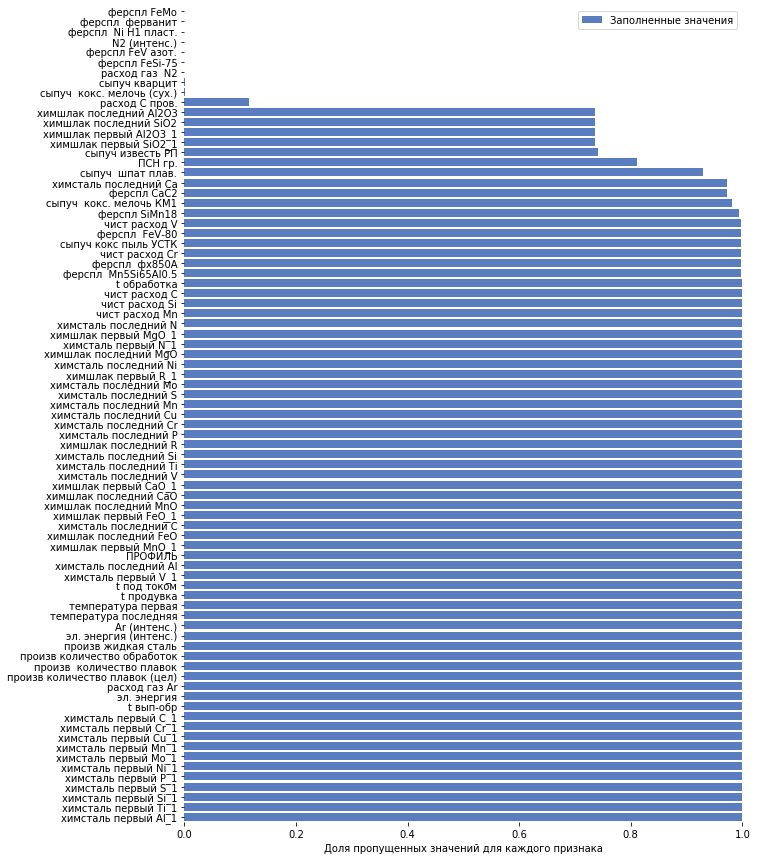

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10, 15))

sns.set_color_codes("muted")
sns.barplot(x="%_fulls", y='feature', data=nuls,
            label="Заполненные значения", color="b")

ax.legend(ncol=2, loc="upper right", frameon=True)
ax.set(xlim=[0, 1], ylabel="",
       xlabel="Доля пропущенных значений для каждого признака")
sns.despine(left=True, bottom=True)

Видим из предыдущего, что есть столбцы, где > 80% данных отсутствует. Их не имеет смысла использовать дальше в прогнозе. 
Также, удалим колонки, которые содержат данные с последнего этапа "из будущего", которые не будут использоваться в прогнозе. Исходный датасет сократился на 27 столбцов.

In [129]:
#df = df.loc[~df['химшлак последний Al2O3'].isnull()]
null_cols = list(nuls.loc[nuls['%_nulls']>0.5].feature)
future_cols = [col for col in df.columns if 'последний' in col.lower()]

df_targets = df[targets]

cols2drop = null_cols+future_cols
df.drop(cols2drop, axis=1, inplace=True)
df.shape

## Исследование фич

In [49]:
# определяем порядковые фичи
for col in df.columns:
    if (df[col].nunique() <= 50) & (df[col].dtype != object) & (col not in targets):
        df[col] = df[col].astype('category')

In [50]:
NUMERICAL = df.select_dtypes(exclude=['category', 'object', 'datetime64']).columns.tolist()
CATEGORICAL = df.select_dtypes(include=['object']).columns.tolist()
ORDINAL = df.select_dtypes(include=['category']).columns.tolist()
for tar in targets:
    if tar in NUMERICAL:
        NUMERICAL.remove(tar)

### Категориальные фичи

In [15]:
CATEGORICAL

['ПРОФИЛЬ']

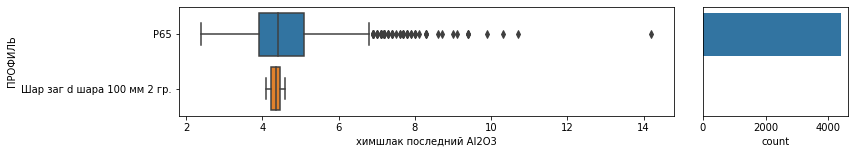

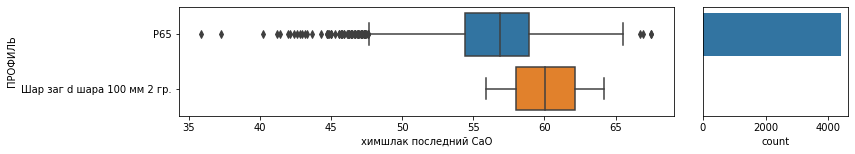

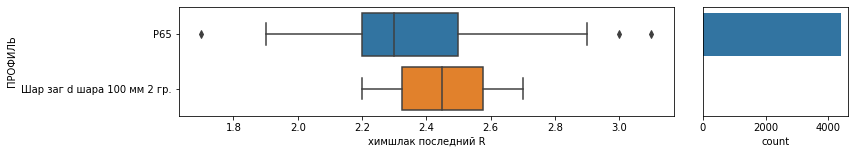

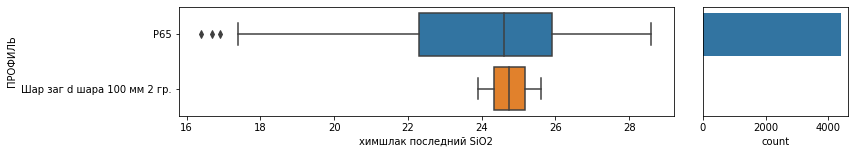

In [16]:
for i in range(len(targets)):
    fig = plt.figure(figsize=(12, 2))
    grid = plt.GridSpec(1, 4, wspace=0.2, hspace=0.1)
    box_ax = fig.add_subplot(grid[0, :3])
    cnt_ax = fig.add_subplot(grid[0, -1])

    sns.boxplot(y='ПРОФИЛЬ', x=targets[i], data=df[['ПРОФИЛЬ', targets[i]]], ax=box_ax)
    sns.countplot(y='ПРОФИЛЬ', data=df[['ПРОФИЛЬ', targets[i]]])
    cnt_ax.set_ylabel('')
    cnt_ax.set_yticks([]);

In [17]:
from collections import Counter
Counter(df['ПРОФИЛЬ'])

Counter({'Р65': 4423, 'Шар заг d шара 100 мм 2 гр.': 2})

Доминирует одна категория, так что можно выбросить столбец и соответствующие строки.

In [18]:
df.drop(df[df['ПРОФИЛЬ']=='Шар заг d шара 100 мм 2 гр.'].index, axis=0, inplace=True)
df.drop('ПРОФИЛЬ', axis=1, inplace=True)

### Порядковые фичи

Так же определим порядковые фичи с доминантым значением. Их можно удалить, так как они не вносят вклад в модель.

In [19]:
def find_ordinal_with_dominant(df, size=50, with_dominant_value=False, max_percent=0.9):
    # if a number of unique varibles is less than or equal to n, this variable is considered as categorial
    names = df.columns
    ordinal_vars = []
    for n in names:
        if df[n].nunique() <= size:
            if with_dominant_value:
                nums = df[n].value_counts().values
                if (len(nums) > 0) and (nums[0] / np.sum(nums) > max_percent ):
                    ordinal_vars.append(n) 
            else:
                ordinal_vars.append(n)
                
    return ordinal_vars

In [20]:
dominant_ords = find_ordinal_with_dominant(df, with_dominant_value=True, max_percent=0.9)
dominant_ords

['произв количество обработок',
 'произв  количество плавок',
 'произв количество плавок (цел)',
 'ферспл CaC2']

<Figure size 432x288 with 0 Axes>

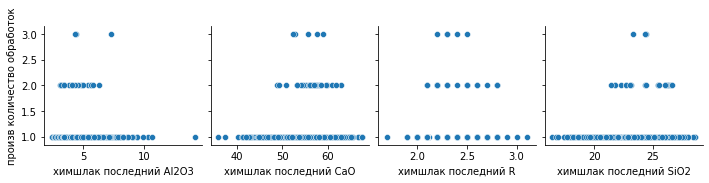

<Figure size 432x288 with 0 Axes>

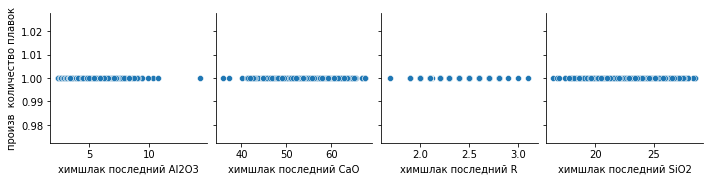

<Figure size 432x288 with 0 Axes>

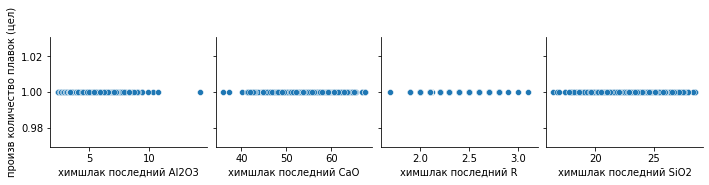

<Figure size 432x288 with 0 Axes>

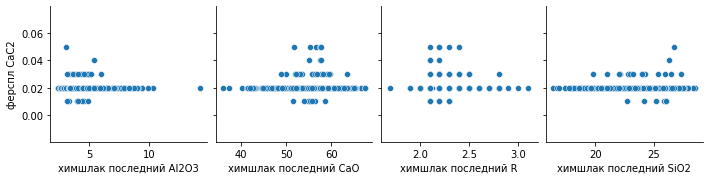

In [21]:
for i in range(len(dominant_ords)):
    plt.figure()
    sns.pairplot(df[[dominant_ords[i]]+targets].astype(float), x_vars=targets, y_vars=dominant_ords[i])
    plt.show();

Столбцы 'произв  количество плавок' и 'произв количество плавок (цел)' имеют одно фиксированное значение для всех таргетов, а значит, не будут вносить вклад в предсказательную модель. Следовательно, эти столбцы можно удалить. Столбцы 'произв количество обработок' и 'ферспл CaC2' могут иметь различные значения, и могут иметь место зависимости между данными параметрами и целевыми переменными. Например (предварительные наблюдения):
- Чем больше значение 'произв количество обработок', тем выше значение целевого параметра 'химшлак последний SiO2'
- Чем больше значение 'ферспл CaC2', тем выше значение целевого параметра 'химшлак последний SiO2'

Для дальнейшего анализа и моделирования оставляем столбцы 'произв количество обработок' и 'ферспл CaC2'

In [22]:
df.drop(dominant_ords[1:-1], axis=1, inplace=True)

### Численные фичи и анализ выбросов

In [23]:
len(NUMERICAL)

36

In [24]:
pd.set_option('display.max_columns', None)
df[NUMERICAL].describe()

t вып-обр  t обработка  t под током   t продувка      ПСН гр.  \
count  4423.000000  4420.000000  4423.000000  4423.000000  3586.000000   
mean     25.792675    45.796633    20.755878    45.716670     2.979857   
std      14.439215     9.932759     4.562035     9.619643     0.732122   
min       0.000000    32.533333     9.383333    31.366667     1.000000   
25%      13.000000    42.033333    17.775000    42.016667     2.519871   
50%      25.000000    44.183333    20.216667    44.066667     3.000000   
75%      36.000000    47.033333    23.016667    47.016667     3.479626   
max      91.000000   294.083333    67.583333   251.000000     6.702208   

       чист расход C  чист расход Cr  чист расход Mn  чист расход Si  \
count    4421.000000     4415.000000     4421.000000     4421.000000   
mean        0.376339        0.125208        0.133968        0.137117   
std         0.075877        0.027275        0.048963        0.038940   
min         0.015240        0.005630        0.000356        0.014973   
25%         0.329225        0.108297        0.100727        0.111405   
50%         0.377575        0.125840        0.133446        0.134319   
75%         0.428215        0.143510        0.167049        0.158528   
max         0.728360        0.291657        0.360708        0.478882   

       чист расход V  температура первая  температура последняя  Ar (интенс.)  \
count    4411.000000         4423.000000            4423.000000   4423.000000   
mean        0.039701         1567.721456            1587.564549     11.343674   
std         0.001596           22.173501              13.786783      3.438866   
min         0.002965         1493.000000            1521.000000      2.456416   
25%         0.038892         1553.000000            1579.000000      8.996150   
50%         0.039631         1568.000000            1585.000000     10.777695   
75%         0.040402         1583.000000            1593.000000     13.076385   
max         0.076948         1653.000000            1647.000000     27.844325   

       эл. энергия (интенс.)  произв жидкая сталь  расход газ Ar  \
count            4423.000000          4423.000000    4423.000000   
mean            12980.828503           114.479765      17.012204   
std               898.920654             2.399149       5.609112   
min              6105.482555           101.200000       3.701000   
25%             12506.683047           113.000000      13.264500   
50%             13031.123139           114.600000      16.108000   
75%             13479.250758           116.000000      19.483500   
max             38216.817594           171.400000      69.001000   

       сыпуч известь РП  сыпуч кокс пыль УСТК  сыпуч  кокс. мелочь КМ1  \
count       3280.000000           4414.000000              4342.000000   
mean           0.130273              0.063312                 0.385319   
std            0.076075              0.069705                 0.093364   
min            0.003000              0.010000                 0.012000   
25%            0.076000              0.050000                 0.327000   
50%            0.116000              0.050000                 0.387000   
75%            0.161000              0.050000                 0.451000   
max            0.690000              0.703000                 0.834000   

       сыпуч  шпат плав.  ферспл  FeV-80  ферспл  Mn5Si65Al0.5  ферспл SiMn18  \
count        4112.000000     4412.000000           4415.000000    4400.000000   
mean            0.054200        0.049993              0.155169       0.207319   
std             0.023248        0.002028              0.050666       0.075464   
min             0.014000        0.003725              0.015000       0.013000   
25%             0.038000        0.049009              0.122500       0.154000   
50%             0.048000        0.049949              0.152000       0.206000   
75%             0.069000        0.050890              0.183000       0.258000   
max             0.224000        0.0

По `max` и `min` видно, что во многих колонках присутсвуют выбросы. Рассмотрим подробнее распределения численных фич.

In [25]:
pd.reset_option('max_columns')

In [70]:
import warnings
warnings.filterwarnings('ignore')

df[NUMERICAL].hist(figsize=(30, 30), bins=50, xlabelsize=8, ylabelsize=8);

Интересно выглядят распределения `ПСН гр.` (можно сказать, что бимодальное) и `сыпуч кокс пыль УСТК` (тоже есть доминирующее значение). Остальные распределения похожи на нормальные либо с перекосом влево.

In [27]:
def std_boxplot(dataframe, features=[], *args, **kwargs):
    x = dataframe[features].copy()
    # standardize features
    for col in x.columns:
        x[col] = (x[col] - x[col].mean()) / x[col].std()
    # draw boxplot
    fig,ax=plt.subplots(*args, **kwargs)
    sns.boxplot(data=x, ax=ax, orient='h')
    ax.set_xticks(np.arange(0,int(max(x.max(axis=1,skipna=True))),5))
    plt.xticks(fontsize='8')
    plt.grid()
    plt.show();
    return x

Построим боксплоты для визуализации и анализа выбросов. 

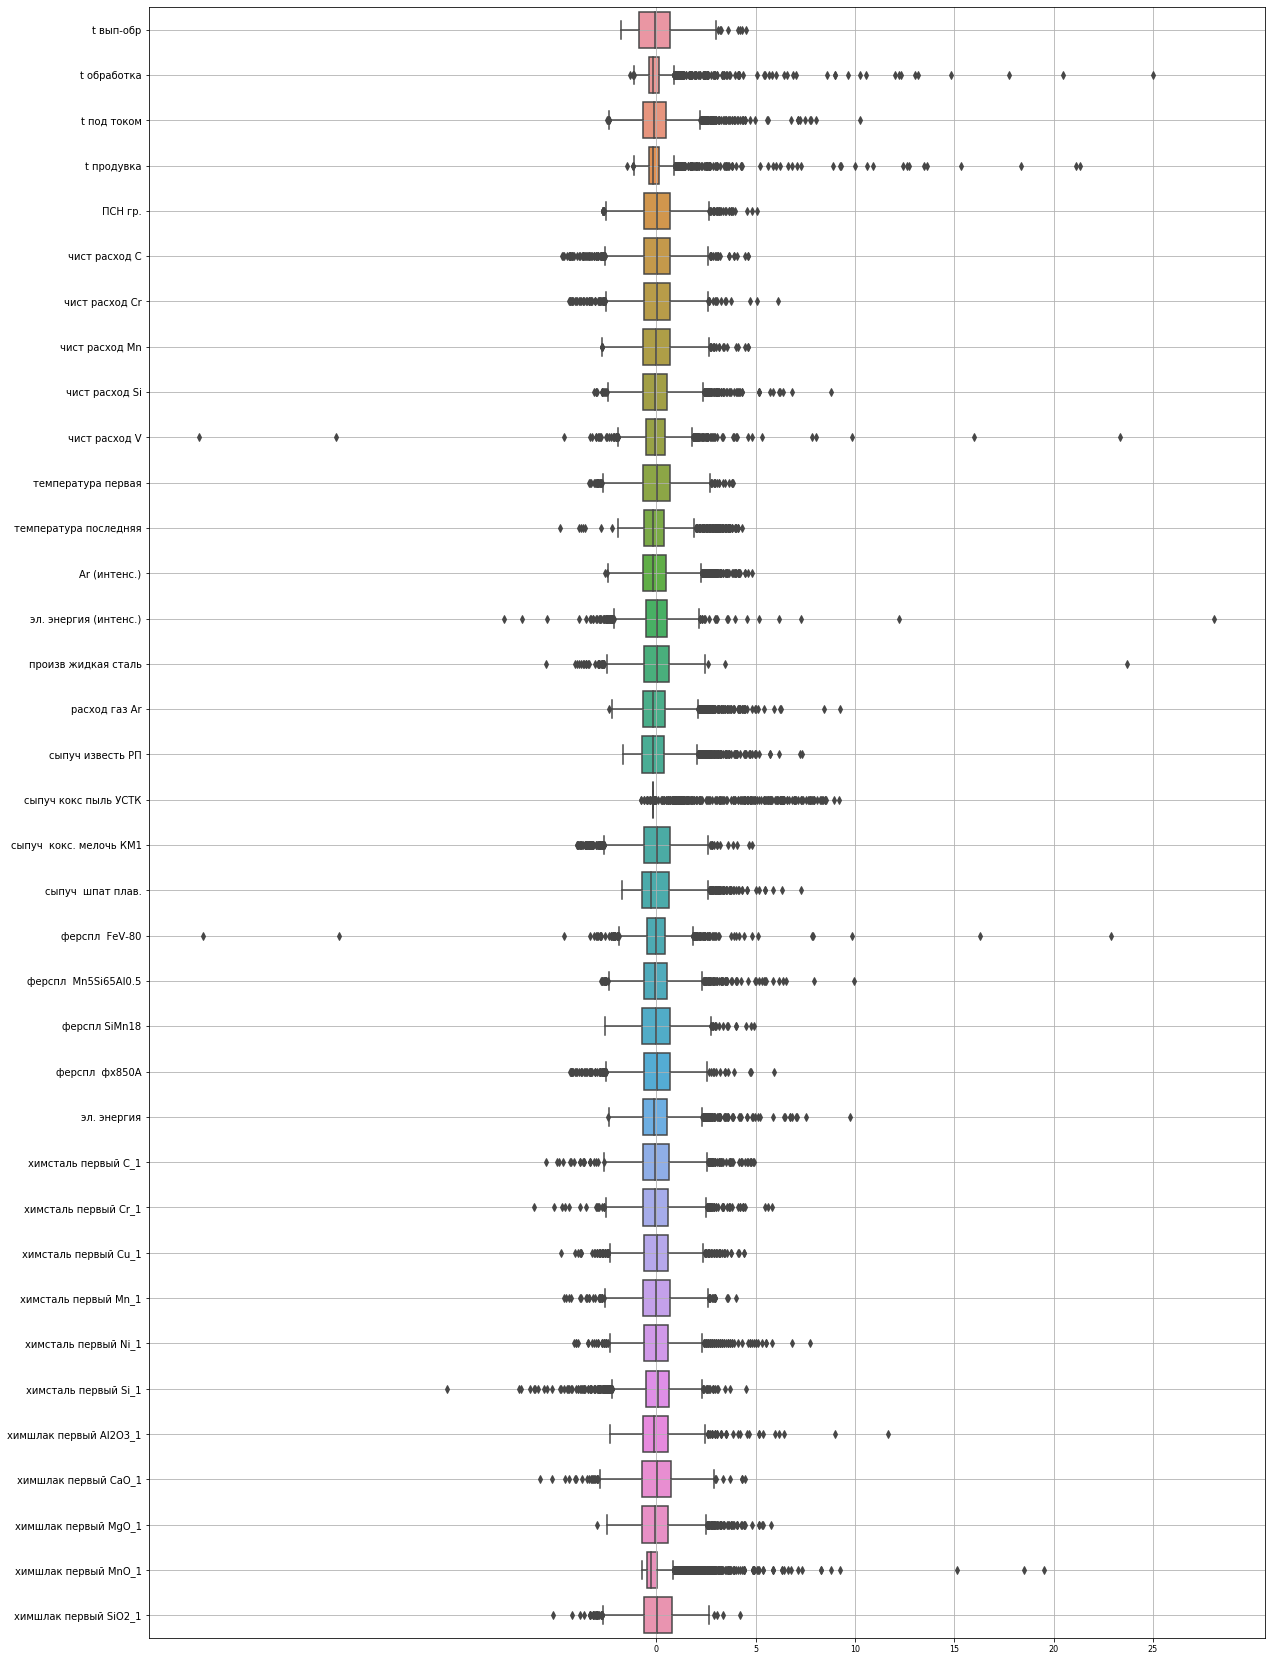

In [28]:
plot = std_boxplot(df, NUMERICAL, figsize=(20,30))

В признаках присутствуют выбросы. Уберем выбросы по квантилям.

In [29]:
def remove_outliers(df, features=[], left_q=.05, right_q=.95):
    outliers_ids = []
    for f in features:
        x = df[f].dropna()
        x = (x - x.mean()) / x.std()
        outliers_ids += list(x[~x.between(x.quantile(left_q), x.quantile(right_q))].index)
    return list(set(outliers_ids))

In [30]:
outliers_ids = remove_outliers(df, NUMERICAL, .001, 0.999) # сильно жёстко не зачищаем, так как данных и так мало
print('Найдено выбросов: {}'.format(len(outliers_ids)))

Найдено выбросов: 203


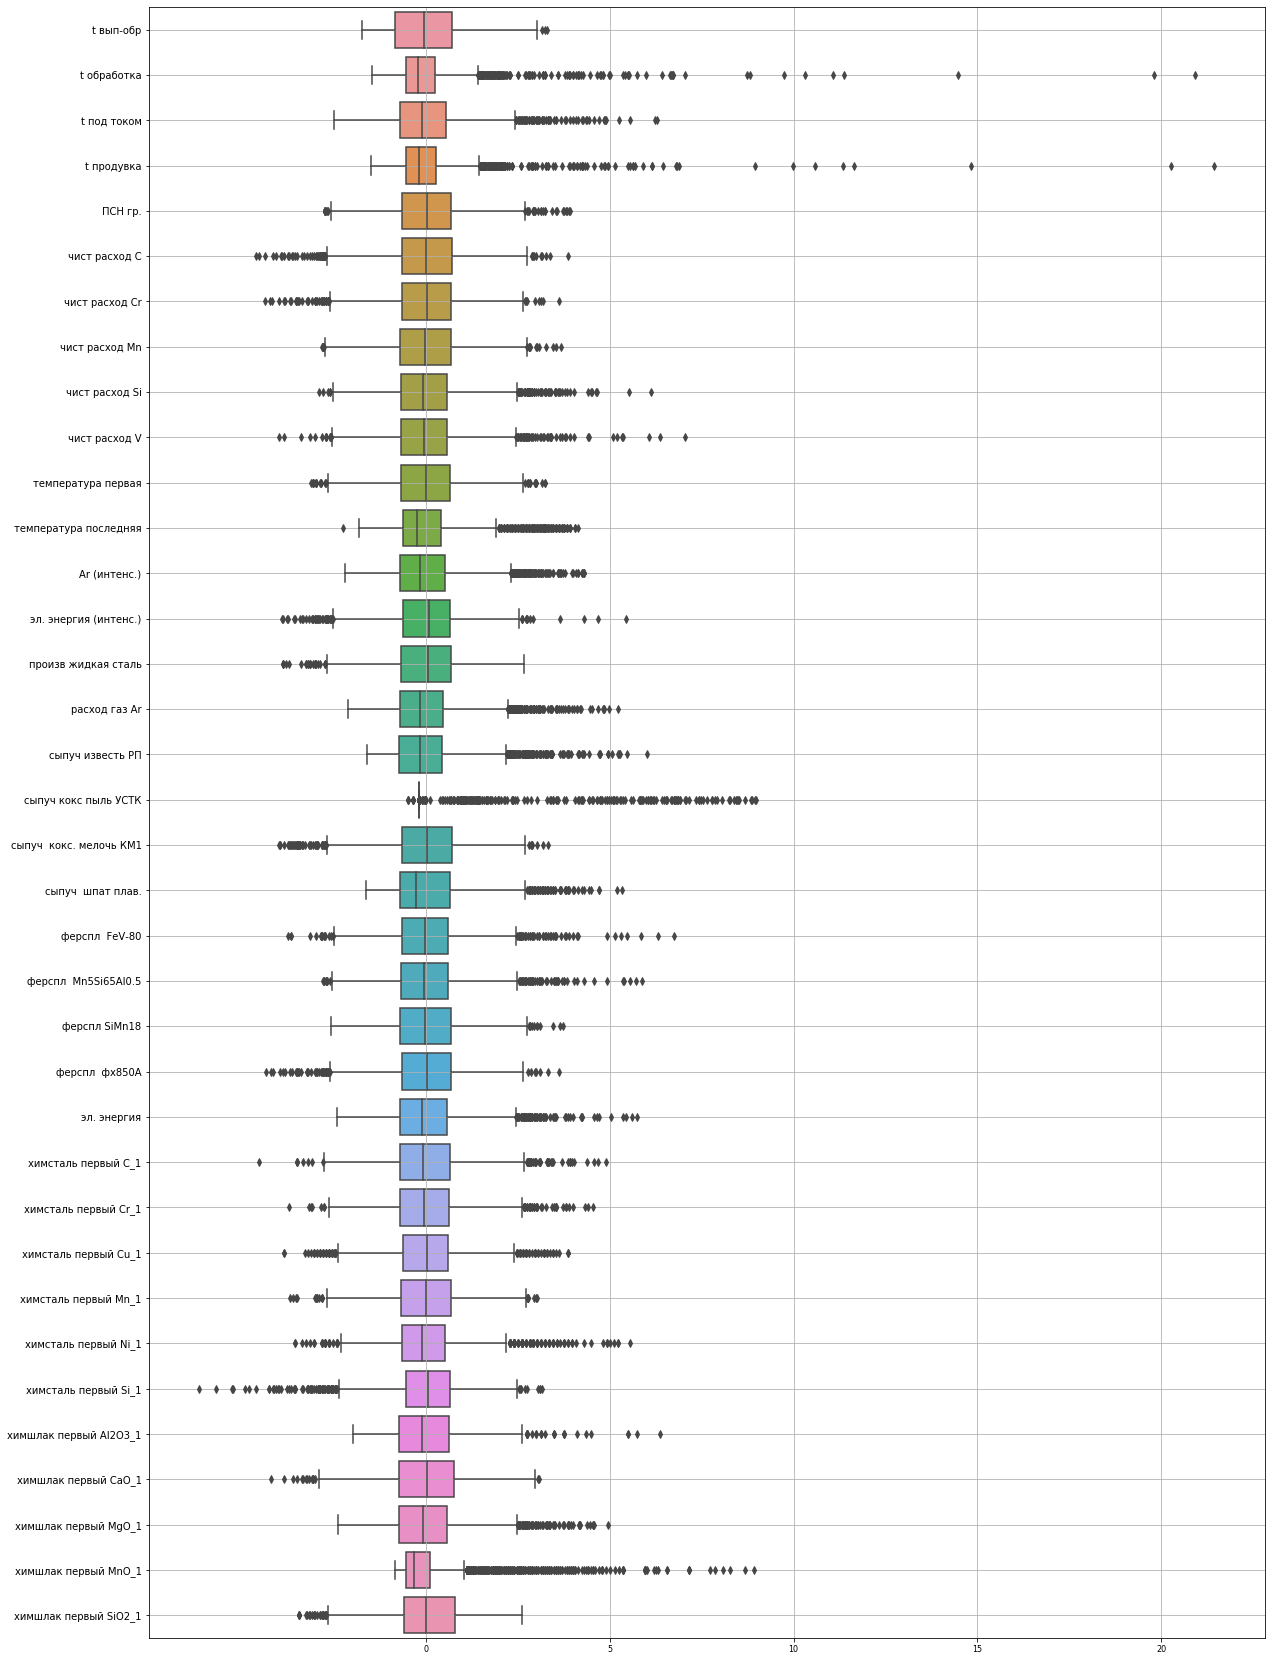

In [31]:
plot = std_boxplot(df.loc[~df.index.isin(outliers_ids)], NUMERICAL, figsize=(20,30))

Ещё осталось несколько значительных выбросов, так что удалим вручную

In [32]:
extra_outliers = []
extra_outliers += plot[(plot >= 5).any(1)].index.tolist()
len(extra_outliers)

149

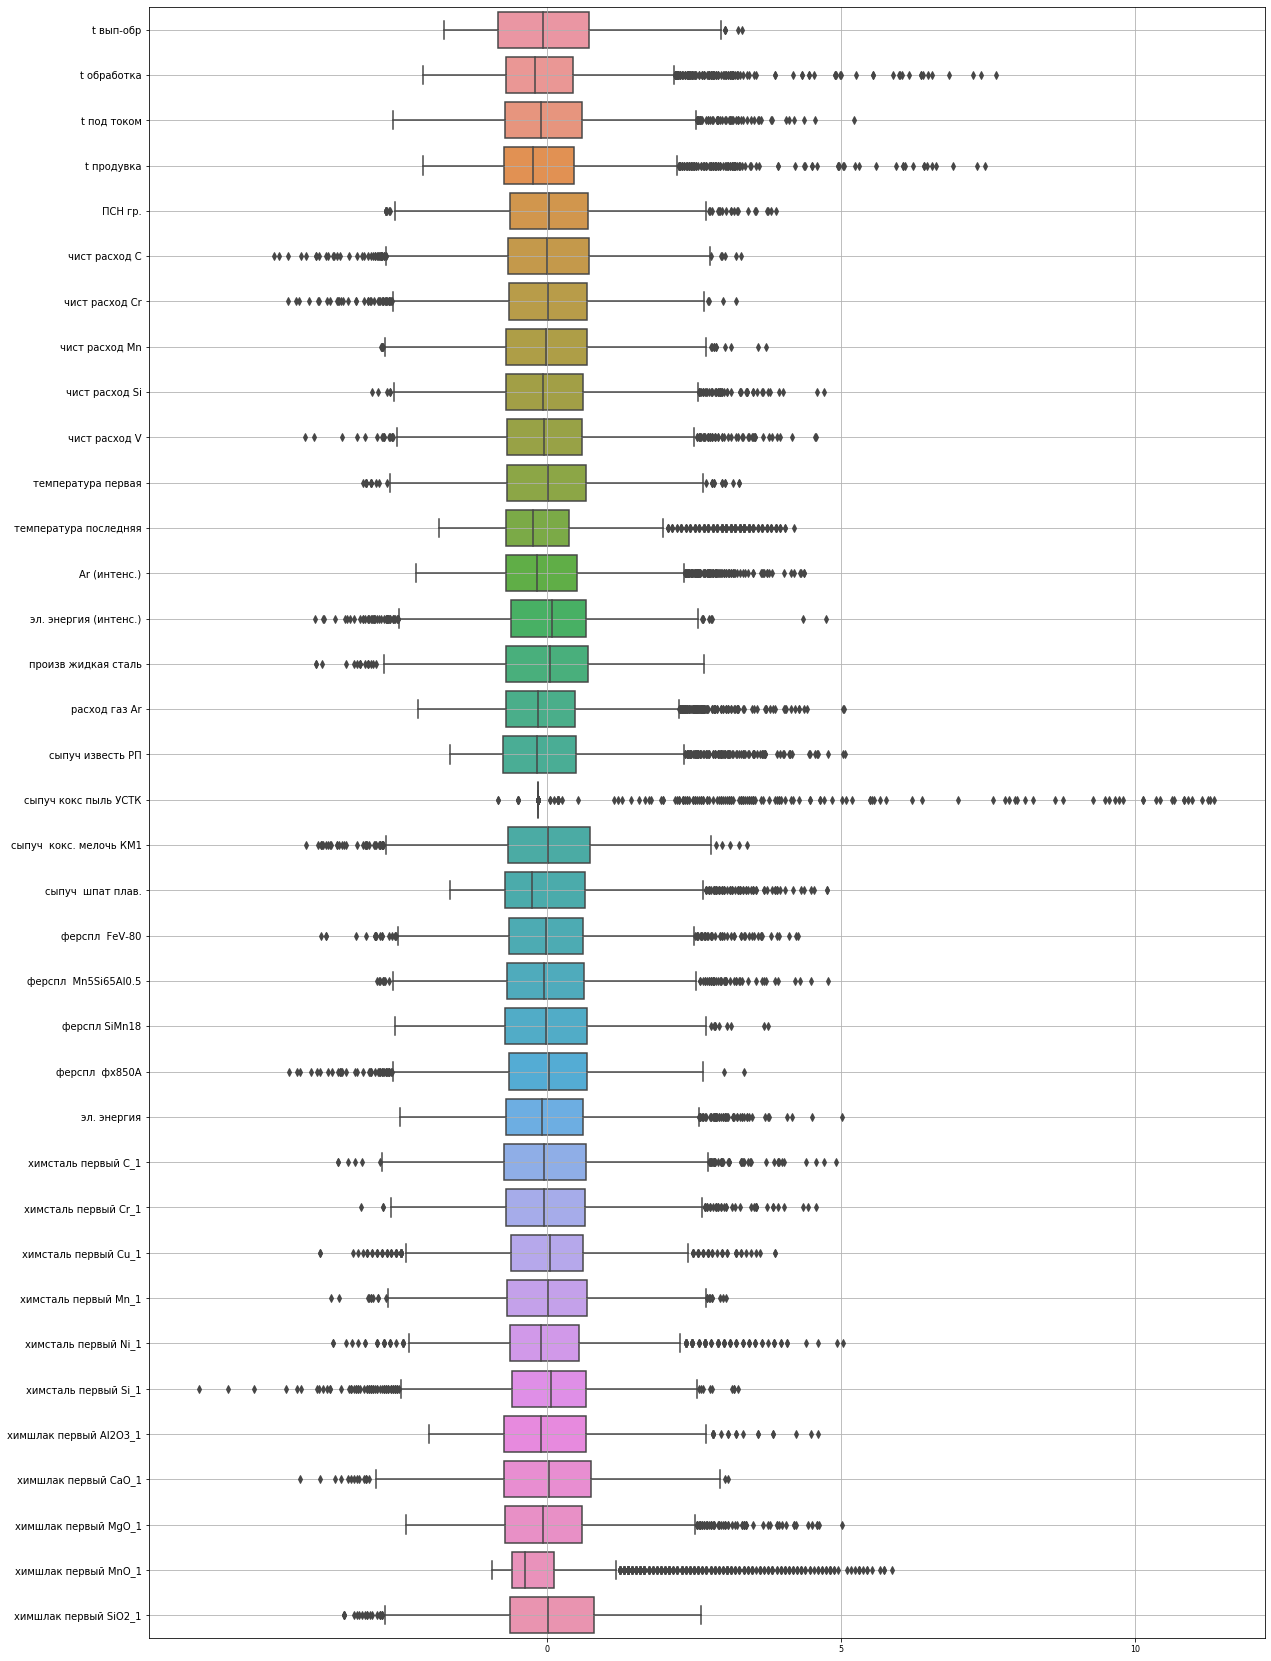

In [33]:
_ = std_boxplot(df.loc[~df.index.isin(outliers_ids+extra_outliers)], NUMERICAL, figsize=(20,30))

% Выбросов

In [34]:
len(set(outliers_ids+extra_outliers)) / df.shape[0]

0.07958399276509157

In [35]:
df.drop(set(outliers_ids+extra_outliers), axis=0, inplace=True)

Посмотрим пэирплоты на наличие явных закономерностей независимых переменных с зависимыми.

<Figure size 432x288 with 0 Axes>

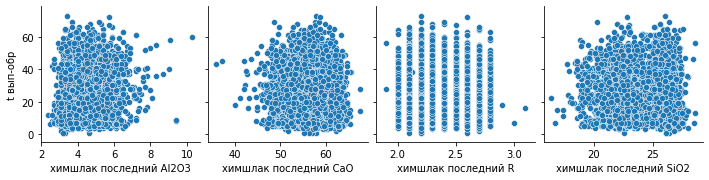

<Figure size 432x288 with 0 Axes>

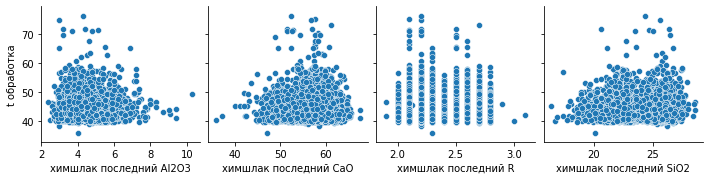

<Figure size 432x288 with 0 Axes>

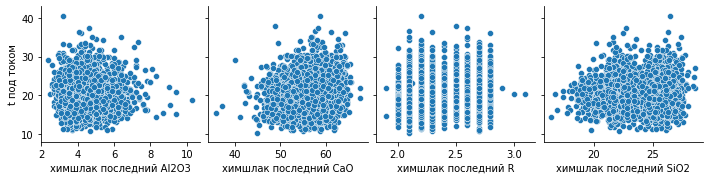

<Figure size 432x288 with 0 Axes>

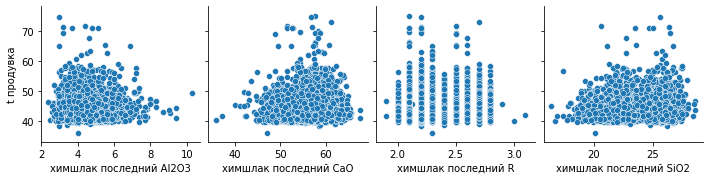

<Figure size 432x288 with 0 Axes>

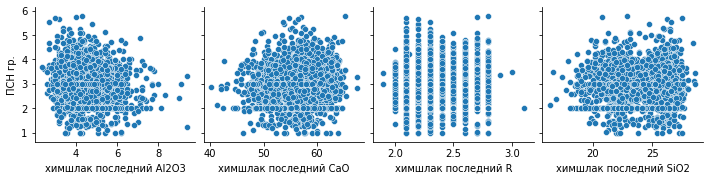

<Figure size 432x288 with 0 Axes>

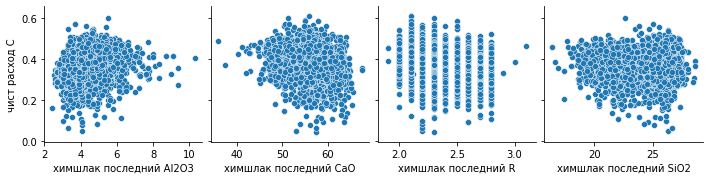

<Figure size 432x288 with 0 Axes>

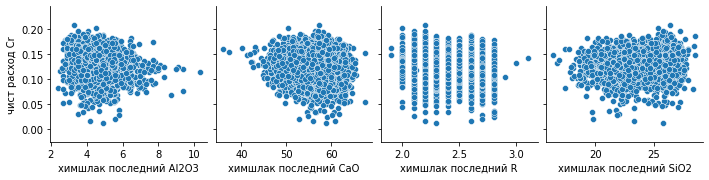

<Figure size 432x288 with 0 Axes>

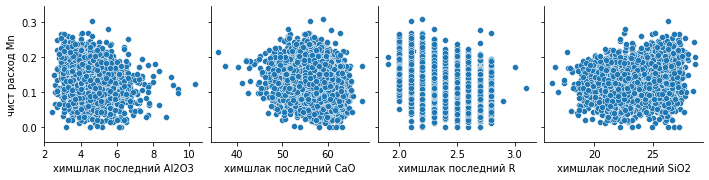

<Figure size 432x288 with 0 Axes>

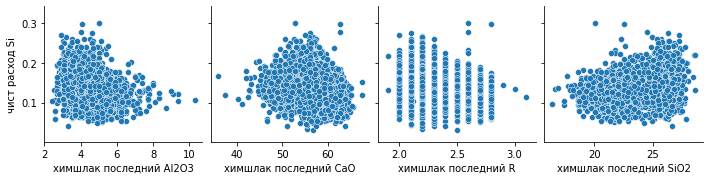

<Figure size 432x288 with 0 Axes>

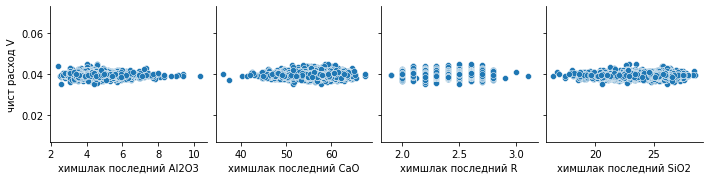

<Figure size 432x288 with 0 Axes>

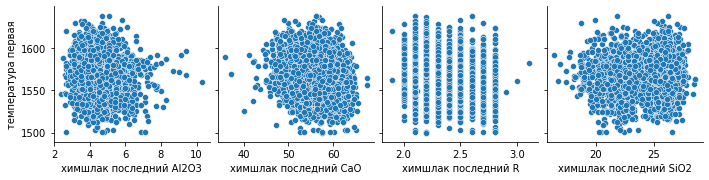

<Figure size 432x288 with 0 Axes>

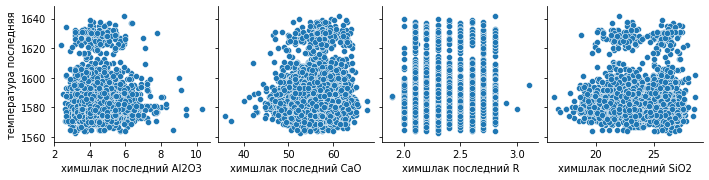

<Figure size 432x288 with 0 Axes>

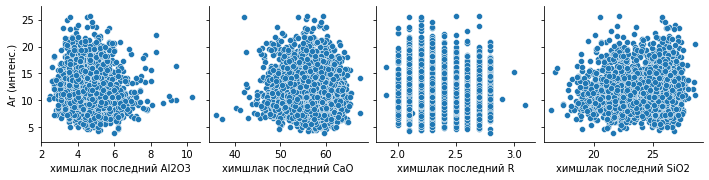

<Figure size 432x288 with 0 Axes>

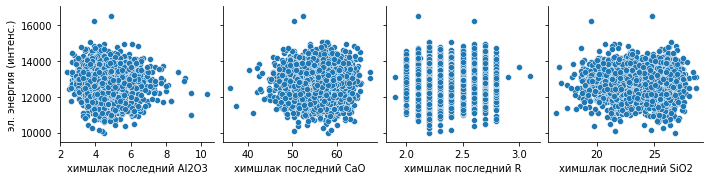

<Figure size 432x288 with 0 Axes>

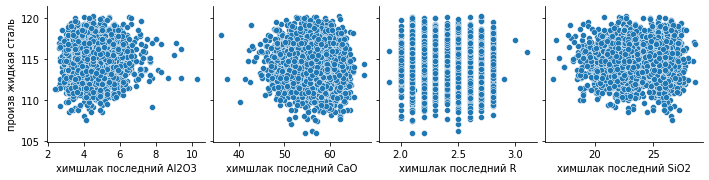

<Figure size 432x288 with 0 Axes>

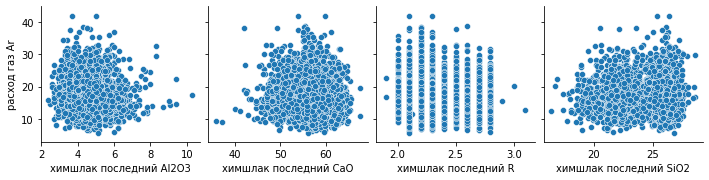

<Figure size 432x288 with 0 Axes>

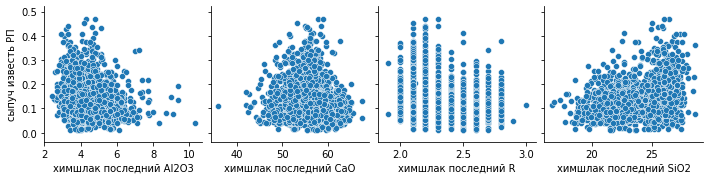

<Figure size 432x288 with 0 Axes>

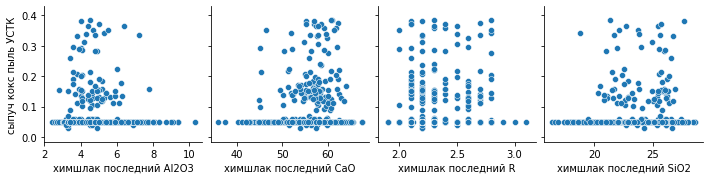

<Figure size 432x288 with 0 Axes>

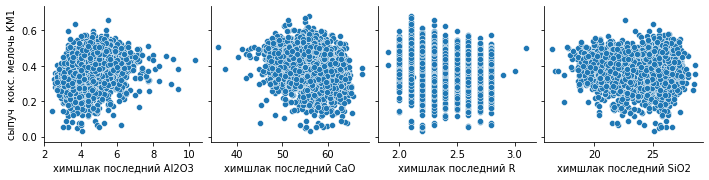

<Figure size 432x288 with 0 Axes>

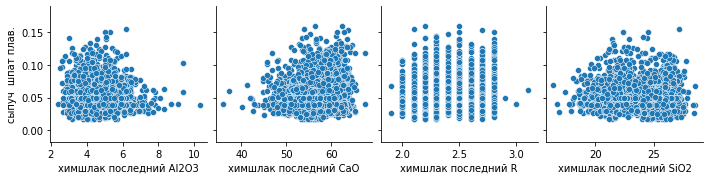

<Figure size 432x288 with 0 Axes>

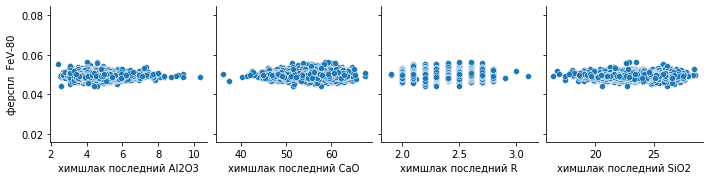

<Figure size 432x288 with 0 Axes>

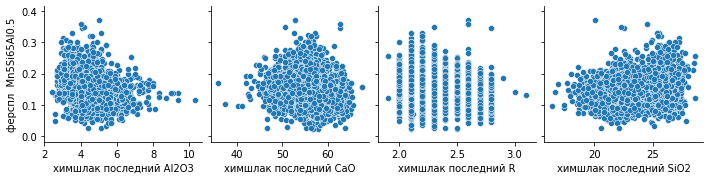

<Figure size 432x288 with 0 Axes>

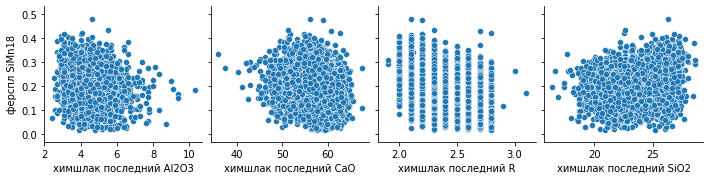

<Figure size 432x288 with 0 Axes>

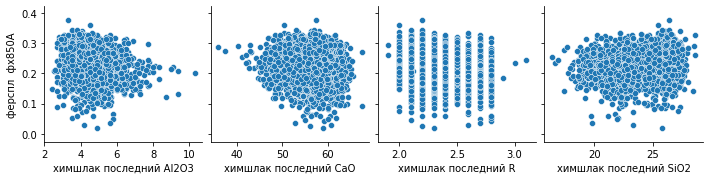

<Figure size 432x288 with 0 Axes>

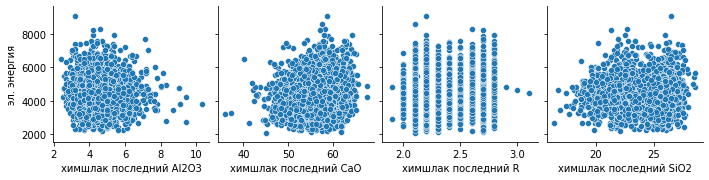

<Figure size 432x288 with 0 Axes>

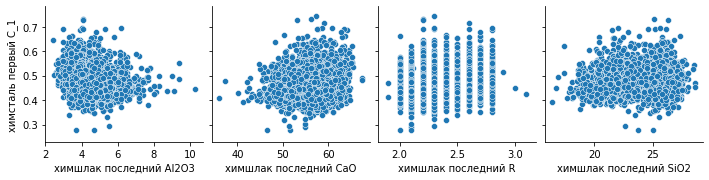

<Figure size 432x288 with 0 Axes>

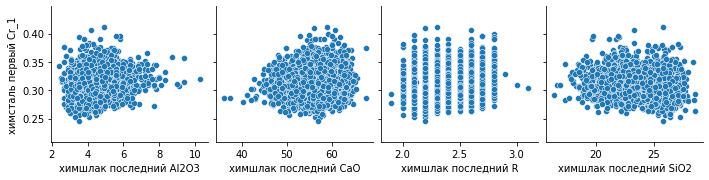

<Figure size 432x288 with 0 Axes>

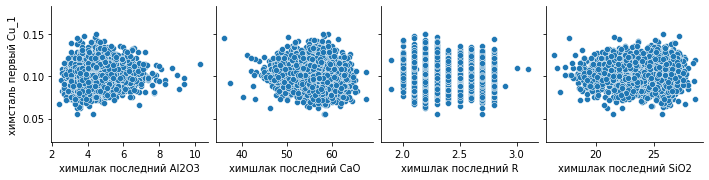

<Figure size 432x288 with 0 Axes>

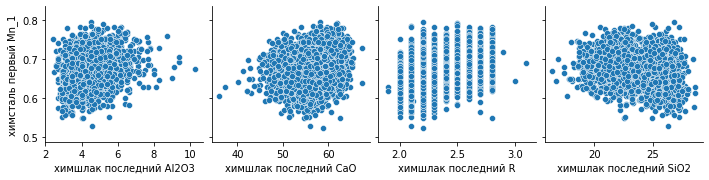

<Figure size 432x288 with 0 Axes>

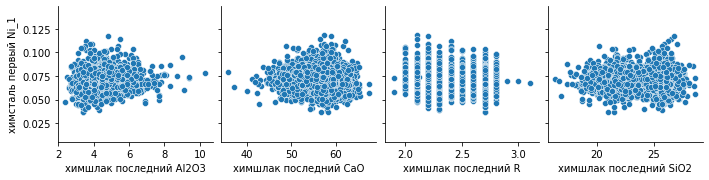

<Figure size 432x288 with 0 Axes>

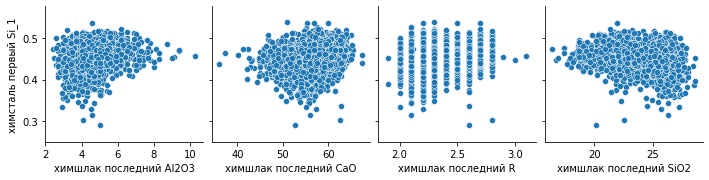

<Figure size 432x288 with 0 Axes>

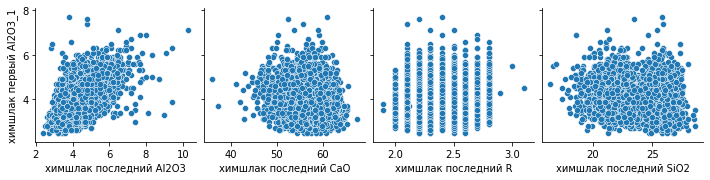

<Figure size 432x288 with 0 Axes>

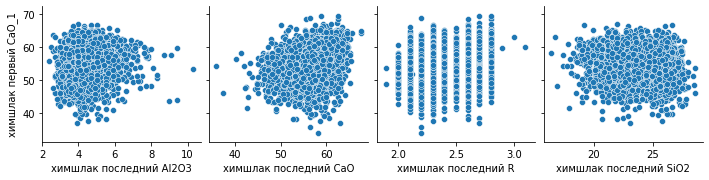

<Figure size 432x288 with 0 Axes>

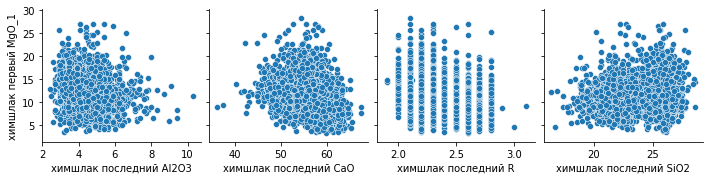

<Figure size 432x288 with 0 Axes>

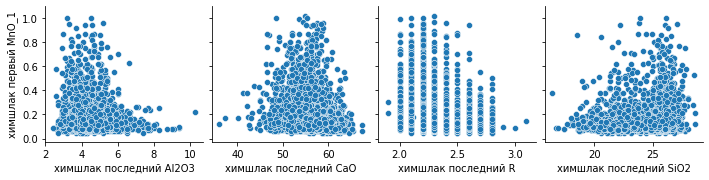

<Figure size 432x288 with 0 Axes>

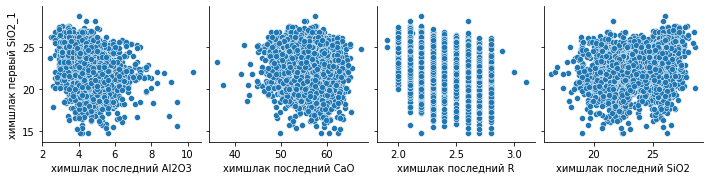

In [36]:
for i in range(len(NUMERICAL)):
    plt.figure()
    sns.pairplot(df[[NUMERICAL[i]]+targets], x_vars = targets, y_vars=NUMERICAL[i])
    plt.show();

Явных закономерностей нет. Однако `химшлак последний R` имеет только определённые значения.

## Дисперсия

Выберем все ненулевые значения в каждом слобце фич, чтобы посчитать дисперсию каждой переменной. Нормализуем выбранные значения, чтобы иметь возможность визуально сравнить данные. Считается, что фичи с околонулевой дисперсией лучше убрать из датасета, т.к. они мешают работе предсказательной модели.

In [37]:
import statistics
from statistics import pvariance

def normalize_list(lst):
    maxx = max(lst)
    minn = min(lst)
    norm = [(x - minn) / (maxx - minn) for x in lst]
    return norm

In [38]:
variances = []
for item in df.columns:
    col = df[item]
    c = [item for item in col if item==item]
    c = normalize_list(c)
    variance = pvariance(c)
    variances.append(variance)

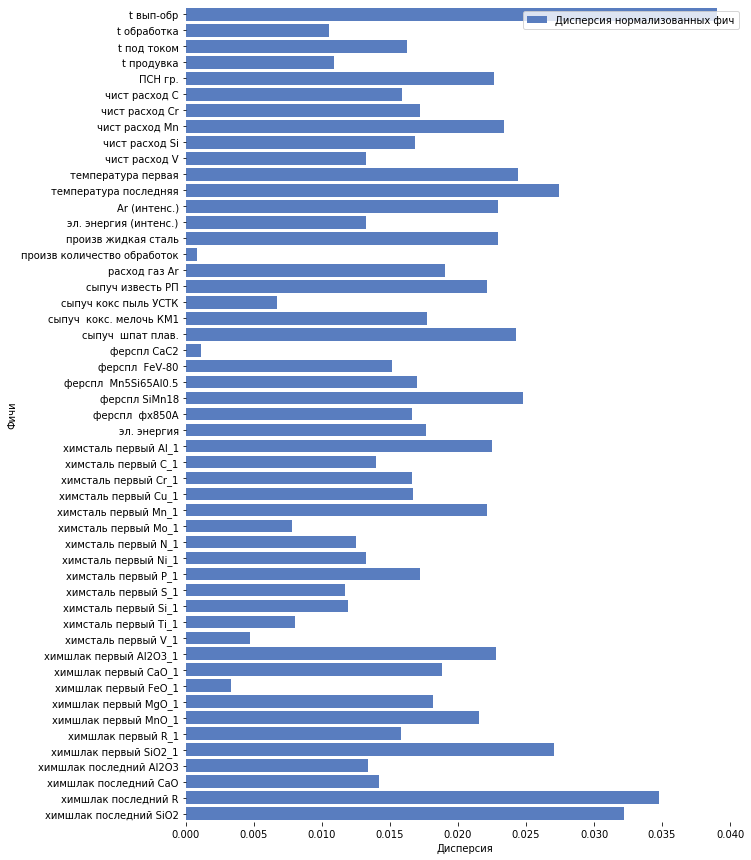

In [39]:
f, ax = plt.subplots(figsize=(10, 15))

sns.set_color_codes("muted")
sns.barplot(x=variances, y=df.columns, label="Дисперсия нормализованных фич", color="b")

ax.legend(ncol=2, loc="upper right", frameon=True)
ax.set(ylabel="Фичи",
       xlabel="Дисперсия")
sns.despine(left=True, bottom=True)

In [40]:
new_cols2drop = [(v, df.columns[i]) for i,v in enumerate(variances) if v<0.005]
new_cols2drop

[(0.000857567419280505, 'произв количество обработок'),
 (0.0011457211025342551, 'ферспл CaC2'),
 (0.004740672607751642, 'химсталь первый V_1'),
 (0.0033236458454006415, 'химшлак первый FeO_1')]

В результате анализа дисперсии признаков, рекомендуется убрать следующие столбцы:
 - 'произв количество обработок'
 - 'ферспл CaC2'
 - 'химсталь первый V_1'
 - 'химшлак первый FeO_1'

## Корелляция

На значение корреляции сильно влияют выбросы, поэтому мы их удалили перед этим этапом.

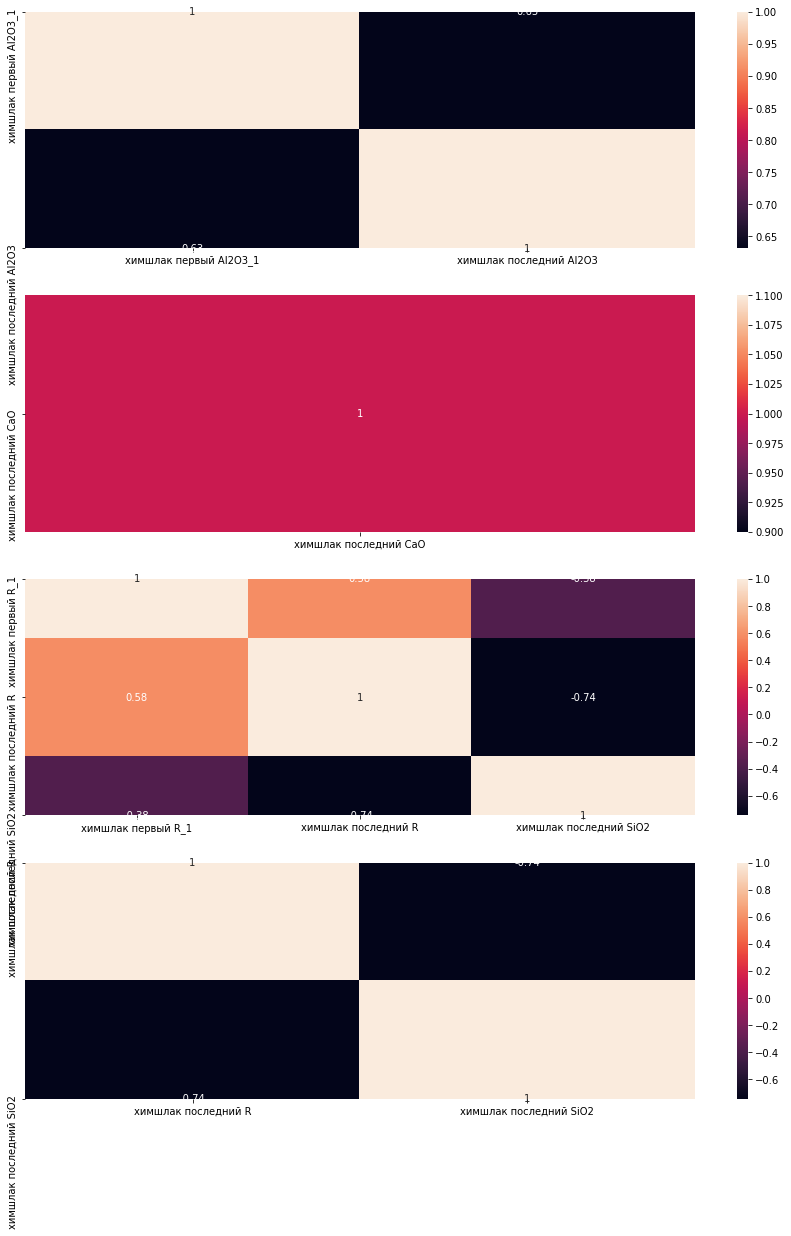

In [41]:
fig,ax = plt.subplots(4, figsize=(15,20))
for i,tar in enumerate(targets):
    corr = df.astype(float).corr()
    condition = (corr[tar] > 0.5) | (corr[tar] < -0.5)
    top_corr = corr.loc[condition, condition]
    sns.heatmap(top_corr, ax=ax[i], annot=True)

**Химшлак последний R** отрицательно коррелирует с **Химшлак последний SiO2**!

# Modelling

In [42]:
df = pd.read_csv('../SUBMISSION/Очищенные данные.csv', sep=',', index_col=0)
df.head()

t вып-обр  t обработка  t под током  t продувка   ПСН гр.  \
nplv                                                                     
г6837?3<87?       29.0    45.366667    24.400000   41.033333       NaN   
г683863<887       24.0    43.350000    17.950000   43.350000       NaN   
г683863<888       17.0    46.183333    19.816667   46.183333       NaN   
г683863<889       20.0    48.500000    17.033333   48.500000       NaN   
г683863<968       20.0    47.516667    24.966667   47.016667  3.107531   

             чист расход C  чист расход Cr  чист расход Mn  чист расход Si  \
nplv                                                                         
г6837?3<87?       0.456460        0.059572        0.117446        0.104762   
г683863<887       0.331665        0.081490        0.132332        0.139860   
г683863<888       0.377945        0.133194        0.221605        0.165186   
г683863<889       0.389875        0.105094        0.169459        0.143024   
г683863<968       0.541855        0.143310        0.234872        0.208873   

             чист расход V  ...  химшлак первый MnO_1  химшлак первый R_1  \
nplv                        ...                                             
г6837?3<87?       0.040938  ...                  0.12                 2.6   
г683863<887       0.041622  ...                  0.12                 2.6   
г683863<888       0.042050  ...                  0.11                 2.4   
г683863<889       0.040967  ...                  0.12                 2.4   
г683863<968       0.042392  ...                  0.51                 2.0   

             химшлак первый SiO2_1  химшлак последний Al2O3  \
nplv                                                          
г6837?3<87?                    NaN                      NaN   
г683863<887                    NaN                      NaN   
г683863<888                    NaN                      NaN   
г683863<889                    NaN                      NaN   
г683863<968                    NaN                      NaN   

             химшлак последний CaO  химшлак последний FeO  \
nplv                                                        
г6837?3<87?                   53.4                    1.0   
г683863<887                   57.2                    0.5   
г683863<888                   60.3                    0.5   
г683863<889                   60.3                    0.6   
г683863<968                   59.2                    1.0   

             химшлак последний MgO  химшлак последний MnO  \
nplv                                                        
г6837?3<87?                    5.8                   0.15   
г683863<887                    8.1                   0.13   
г683863<888                    6.3                   0.12   
г683863<889                    4.5                   0.09   
г683863<968                    7.1                   0.19   

             химшлак последний R  химшлак последний SiO2  
nplv                                                      
г6837?3<87?                  2.6                     NaN  
г683863<887                  2.3                     NaN  
г683863<888                  2.6                     NaN  
г683863<889                  2.5                     NaN  
г683863<968                  2.2                     NaN  

[5 rows x 68 columns]

In [43]:
initial_features = df.columns

### Imputer

In [54]:
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

def simple_impute(df, col, strategy):
    imputer = SimpleImputer(missing_values=np.nan, strategy=strategy)
    imp_col = imputer.fit_transform(df[col].to_numpy().reshape(-1, 1))
    new_col = col+'_'+strategy
    df[new_col] = imp_col
    return df, new_col

def knn_impute(df, col):
    imputer = KNNImputer(n_neighbors=2)
    imp_col = imputer.fit_transform(df[col].to_numpy().reshape(-1, 1))
    imp_col = [item[0] for item in imp_col.tolist()]
    new_col = col+'_knn'
    df[new_col] = imp_col
    return df, new_col

In [45]:
cols = set(df.columns) - set(targets)
nan_cols=[col for col in cols if df[col].isnull().values.any()]

In [46]:
#Стратегия mean
df_imp = df[nan_cols]
mean_cols=[]
for col in nan_cols:
    df_imp, new_col = simple_impute(df_imp, col, 'mean')
    mean_cols.append(new_col)

#Стратегия median 
median_cols=[]
for col in nan_cols:
    df_imp, new_col = simple_impute(df_imp, col, 'median')
    median_cols.append(new_col)
    
#Стратегия freq 
freq_cols = []
for col in nan_cols:
    df_imp, new_col = simple_impute(df_imp, col, 'most_frequent')
    freq_cols.append(new_col)
    
#Стратегия knn 
knn_cols = []
for col in nan_cols:
    df_imp, new_col = knn_impute(df_imp, col)
    knn_cols.append(new_col)

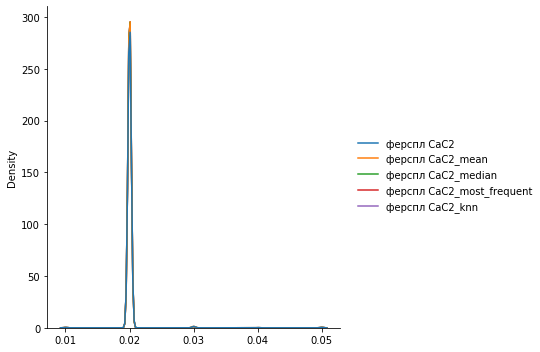

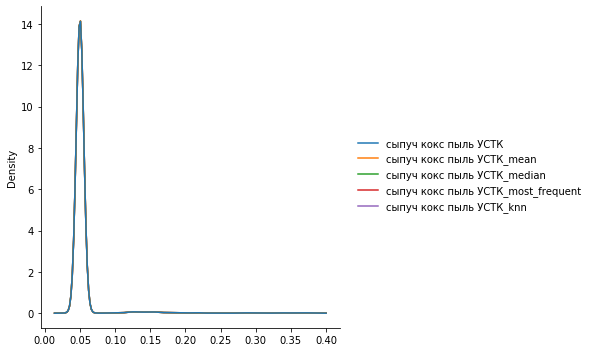

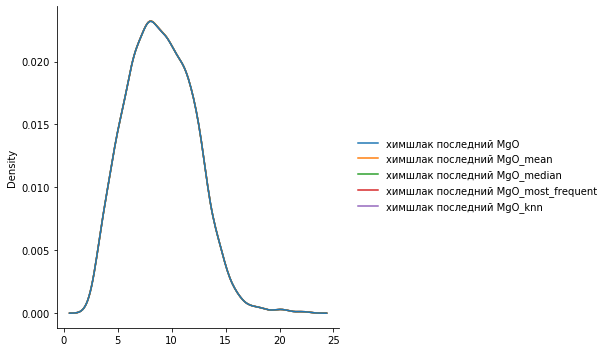

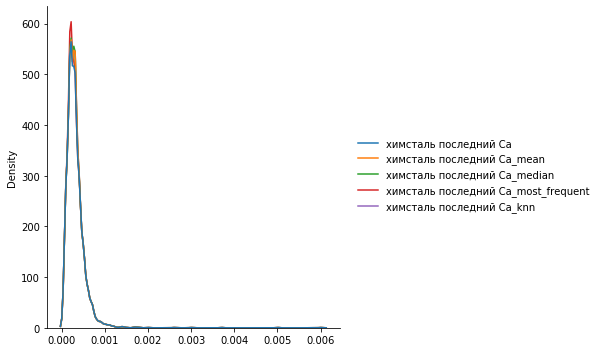

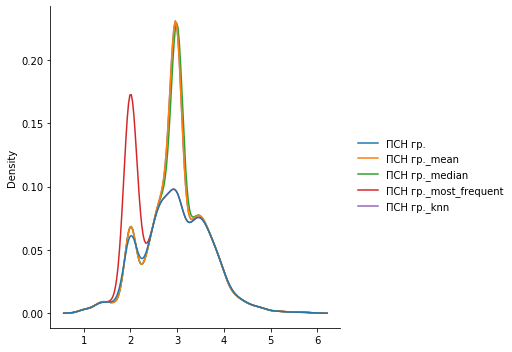

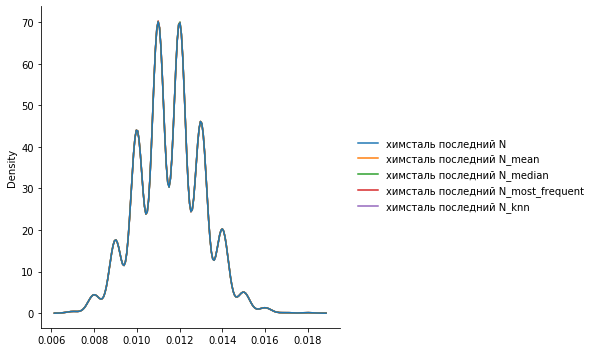

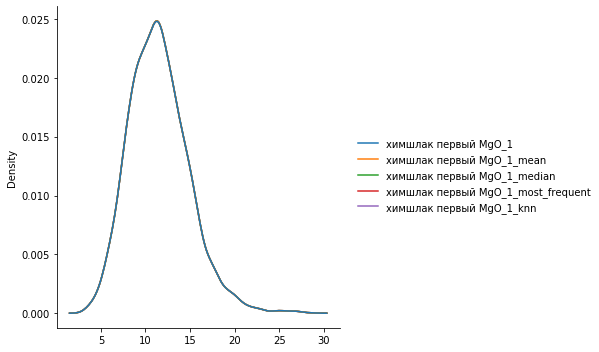

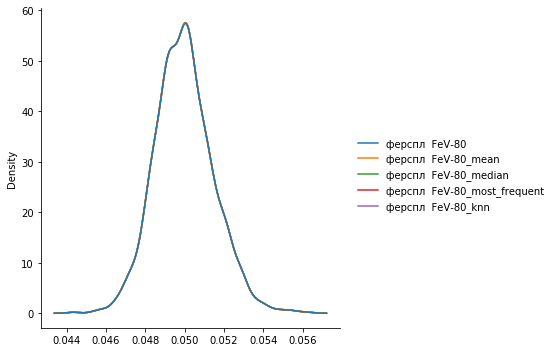

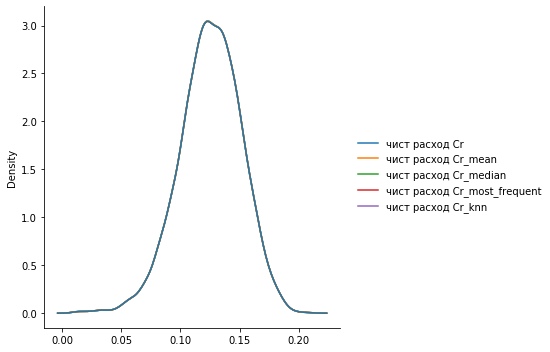

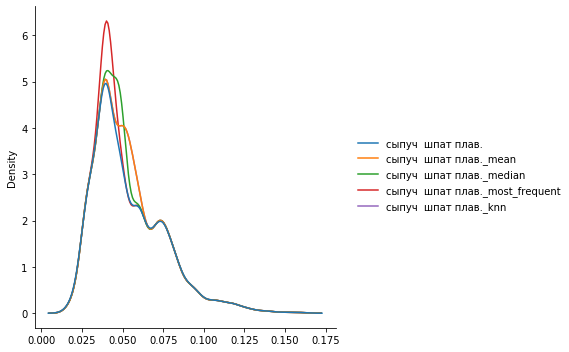

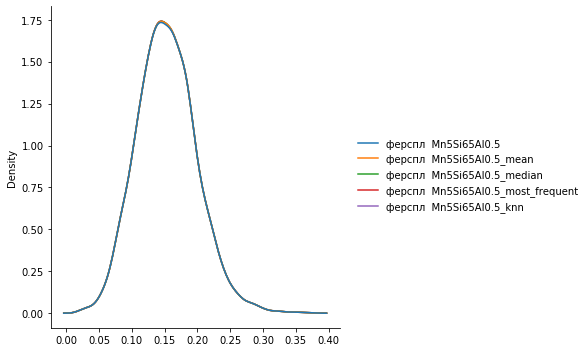

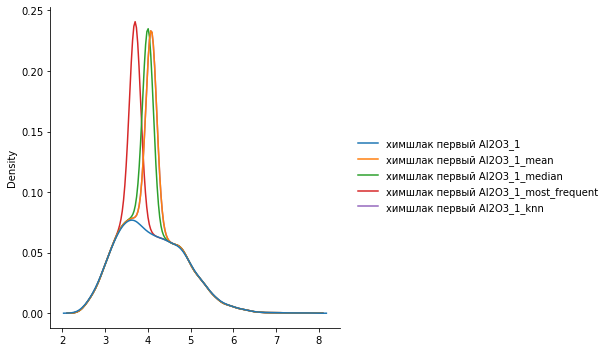

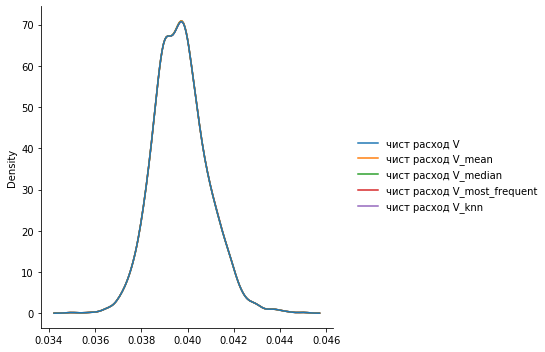

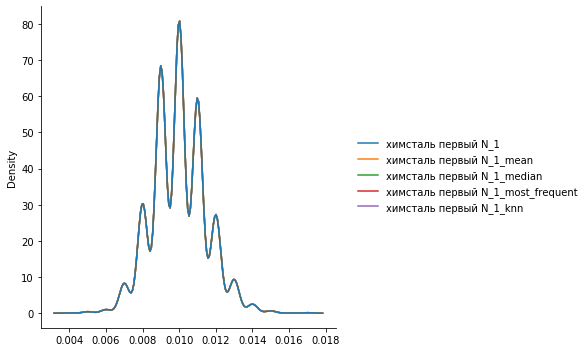

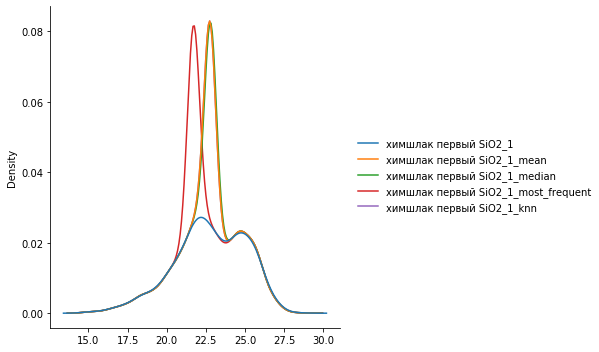

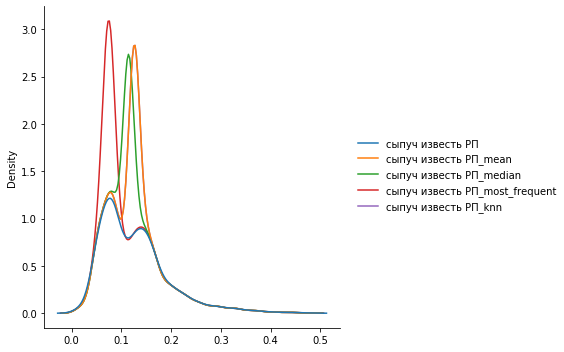

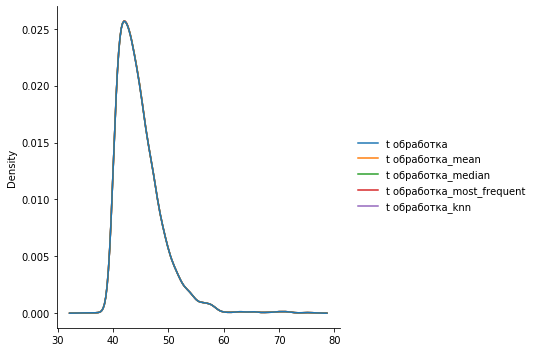

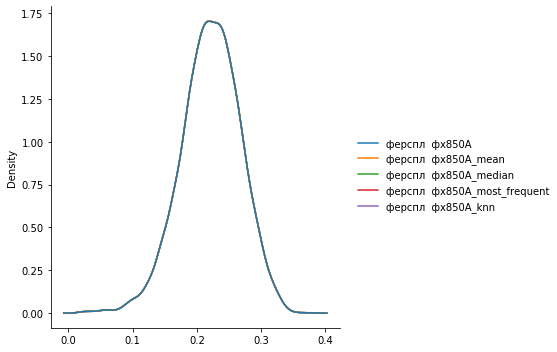

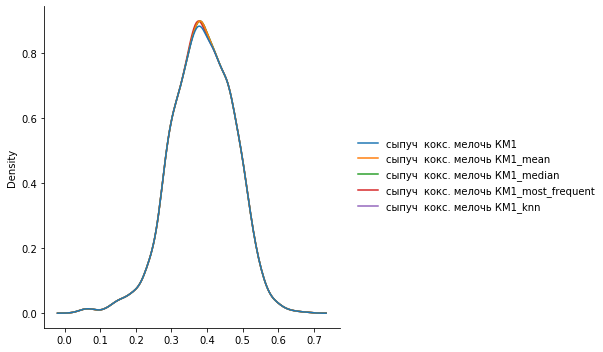

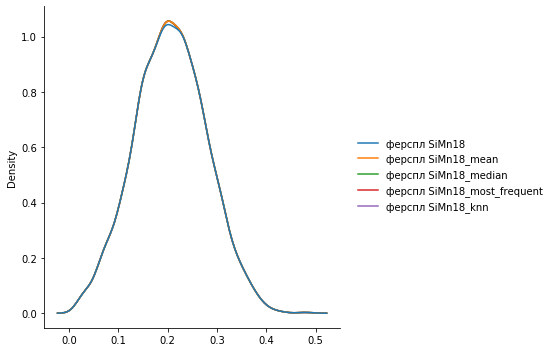

In [47]:
for ind, item in enumerate(nan_cols):
    c=[item, mean_cols[ind],median_cols[ind],freq_cols[ind], knn_cols[ind]]
    sns.displot(df_imp[c], kind='kde')
    plt.show()

kNN Imputer не влияет на изначальные распределения и подходит для всех типов фич. Используем его, чтобы заполнить оставшиеся пропуски.

In [48]:
def knn_impute(df, col):
    imputer = KNNImputer(n_neighbors=2)
    imp_col = imputer.fit_transform(df[col].to_numpy().reshape(-1, 1))
    imp_col = [item[0] for item in imp_col.tolist()]
    df[col] = imp_col

#Стратегия knn 
for col in nan_cols:
    knn_impute(df, col)

### Feature correlation and engineering

Сильно коррелирующие между собой фичи можно использовать для создания новых или просто удалить одну из пары.

In [49]:
pearson_corr = df.drop(targets, axis=1).corr(method='pearson', min_periods=50)
pos_corr = np.abs(np.nan_to_num(pearson_corr.values, 0.0))
strong_corr_pairs = []
for i in range(1, len(pos_corr)):
    if np.max(pos_corr[i, :i]) >= 0.7:
        j = np.argmax(pos_corr[i, :i])
        strong_corr_pairs.append((i, j, pearson_corr.values[i, j]))

In [50]:
cols = df.drop(targets, axis=1).columns
cols_dict = dict(list(zip(range(len(cols)), cols)))

In [51]:
# сильно коррелирующие между собой фичи
strong_corr_df = pd.DataFrame(strong_corr_pairs).replace(cols_dict).sort_values(2, ascending=False)
strong_corr_df

0                     1         2
6            ферспл  фх850А        чист расход Cr  0.997215
14    химсталь последний Ni  химсталь первый Ni_1  0.993602
12    химсталь последний Cu  химсталь первый Cu_1  0.989651
5             ферспл SiMn18        чист расход Mn  0.989589
0                t продувка           t обработка  0.987660
3            ферспл  FeV-80         чист расход V  0.985563
7               эл. энергия           t под током  0.962633
15     химсталь последний P   химсталь первый P_1  0.958748
13    химсталь последний Mo  химсталь первый Mo_1  0.957194
1             расход газ Ar          Ar (интенс.)  0.948073
2   сыпуч  кокс. мелочь КМ1         чист расход C  0.944099
4      ферспл  Mn5Si65Al0.5        чист расход Si  0.929269
8       химсталь первый C_1         чист расход C -0.938656
11     химсталь первый Si_1        чист расход Si -0.940762
9      химсталь первый Cr_1        чист расход Cr -0.980687
10     химсталь первый Mn_1        чист расход Mn -0.982712

In [52]:
# по смыслу можно попробовать разницу или отношение пар
cols_for_engineering = ['химсталь последний Ni',
                        'химсталь последний Cu',
                        'химсталь последний P',
                        'химсталь последний Mo',
                        'химшлак первый SiO2_1',
                        'химсталь первый C_1',
                        'химсталь первый Si_1',
                        'химсталь первый Cr_1']
corr_cols_to_drop = [col for col in strong_corr_df[0] if col not in cols_for_engineering]

In [53]:
pairs = strong_corr_df[strong_corr_df[0].isin(cols_for_engineering)][[0,1]].values
pairs

array([['химсталь последний Ni', 'химсталь первый Ni_1'],
       ['химсталь последний Cu', 'химсталь первый Cu_1'],
       ['химсталь последний P', 'химсталь первый P_1'],
       ['химсталь последний Mo', 'химсталь первый Mo_1'],
       ['химсталь первый C_1', 'чист расход C'],
       ['химсталь первый Si_1', 'чист расход Si'],
       ['химсталь первый Cr_1', 'чист расход Cr']], dtype=object)

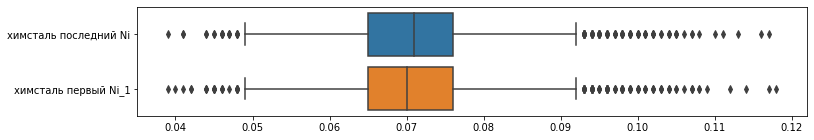

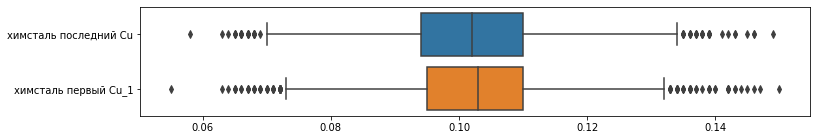

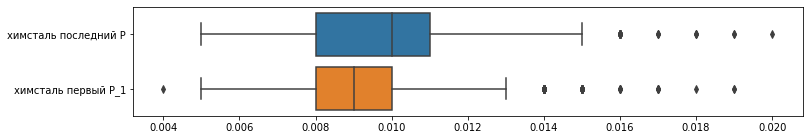

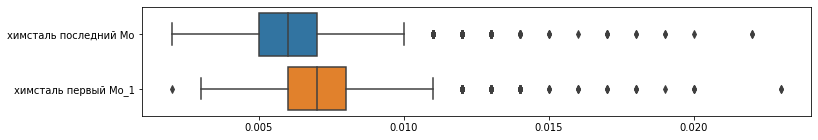

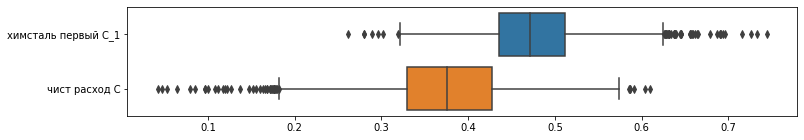

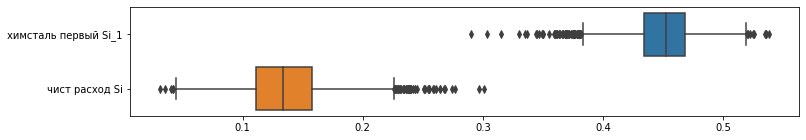

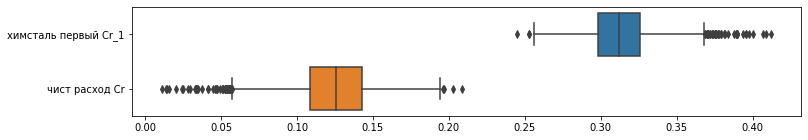

In [54]:
for pair in pairs:
    fig = plt.figure(figsize=(12, 2))
    sns.boxplot(data=df[pair], orient='h')

Одну из колонок с Ni и Cu можно убрать, так как почти дублируются.

In [55]:
# corr_cols_to_drop += ['химсталь первый Cu_1', 'химсталь первый Ni_1']
# corr_cols_to_drop = ['химсталь первый Cu_1', 'химсталь первый Ni_1']

In [56]:
# df.drop(corr_cols_to_drop, axis=1, inplace=True)

Попробуем отношение.

In [57]:
def safe_division(x, y):
    if (x != x) | (y != y) | (y == 0):
        return 0
    return x / y

# cols_to_drop_2=[]
for pair in pairs:
#     if (pair[0] not in corr_cols_to_drop) & (pair[1] not in corr_cols_to_drop):
    new_col = pair[0]+'_'+pair[1]+'_ratio'
    df[new_col] = df.apply(lambda x: safe_division(x[pair[0]],x[pair[1]]), axis=1)
#     cols_to_drop_2 += [pair[0], pair[1]]

In [58]:
# df.drop(cols_to_drop_2, axis=1, inplace=True)

*Комментарий к закомменченному коду*: в итоге больший набор фич лучше повлиял на результаты прогноза, поэтому ничего не выбрасываем.

Попробуем разность температур.

In [29]:
import itertools
t_features = ['t вып-обр', 't обработка', 't под током', 't продувка']
t_combinations = list(itertools.combinations(t_features, 2))

In [60]:
for pair in t_combinations:
    new_col = pair[0]+'_'+pair[1]+'_sub'
    df[new_col] = df.apply(lambda x: x[pair[0]]-x[pair[1]], axis=1)

### Feature importance (potential)

In [61]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

In [62]:
data = df.dropna().astype(float)
data = (data - data.mean()) / (data.std() + 0.0001)

In [63]:
x_train, x_test, y_train, y_test = train_test_split(
    data.drop(columns = targets),
    data[targets],
    test_size=0.3,
    shuffle = True)

In [64]:
clf = linear_model.Lasso(alpha=0.07)
clf.fit(x_train, y_train)

Lasso(alpha=0.07)

In [65]:
names = df.drop(columns = targets).columns
for i,m in enumerate(clf.coef_):
    print('Потенциальные фичи для {}'.format(targets[i]))
    print(names[np.where(m != 0)].values)

Потенциальные фичи для химшлак последний Al2O3
['чист расход Si' 'химсталь первый C_1' 'химшлак первый Al2O3_1'
 'химшлак первый R_1' 'химшлак первый SiO2_1' 'химшлак последний FeO'
 'химшлак последний MgO' 'химшлак последний MnO']
Потенциальные фичи для химшлак последний CaO
['чист расход C' 'сыпуч  кокс. мелочь КМ1' 'эл. энергия'
 'химсталь первый S_1' 'химсталь последний Cu' 'химшлак первый Al2O3_1'
 'химшлак первый CaO_1' 'химшлак первый MnO_1' 'химшлак первый R_1'
 'химшлак последний FeO' 'химшлак последний MgO']
Потенциальные фичи для химшлак последний R
['ферспл SiMn18' 'химшлак первый R_1' 'химшлак последний MgO'
 'химшлак последний MnO' 'химсталь первый Si_1_чист расход Si_ratio']
Потенциальные фичи для химшлак последний SiO2
['ферспл SiMn18' 'химсталь первый Si_1' 'химсталь последний N'
 'химшлак первый Al2O3_1' 'химшлак первый R_1' 'химшлак первый SiO2_1'
 'химшлак последний FeO' 'химшлак последний MgO' 'химшлак последний MnO']


In [66]:
important_features = dict.fromkeys(targets, {})
for i,m in enumerate(clf.coef_):
    important_features[targets[i]] = list(names[np.where(m != 0)].values)

### Linear Regression

In [67]:
df[targets].count() / df.shape[0]

химшлак последний Al2O3    0.742843
химшлак последний CaO      1.000000
химшлак последний R        1.000000
химшлак последний SiO2     0.742843
dtype: float64

In [68]:
new_pairs = [['химшлак первый CaO_1', 'химшлак последний CaO'], ['химшлак первый R_1', 'химшлак последний R']]
for pair in new_pairs:
    new_col = pair[0]+'_'+pair[1]+'_ratio'
    df[new_col] = df.apply(lambda x: safe_division(x[pair[0]],x[pair[1]]), axis=1)

In [69]:
pred_idx = df[df[targets].isna().any(1)].index
train_test_idx = df[~df[targets].isna().any(1)].index

In [90]:
TARGETS = targets

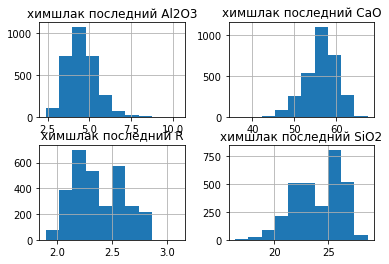

In [91]:
df.loc[train_test_idx, targets].astype(float).hist(); # посмотрим распределения таргетов

Можно применить log-трансформацию.

In [92]:
# определяем порядковые фичи
for col in df.columns:
    if (df[col].nunique() <= 50) & (df[col].dtype != object) & (col not in targets):
        df[col] = df[col].astype('category')

In [93]:
NUMERICAL = df.select_dtypes(exclude=['category', 'object', 'datetime64']).columns.tolist()
ORDINAL = df.select_dtypes(include=['category']).columns.tolist()
for tar in targets:
    if tar in NUMERICAL:
        NUMERICAL.remove(tar)

In [74]:
target = 'химшлак последний Al2O3'
features = set(df.columns) - set(targets)
# features = important_features[target]
X, y = df.loc[train_test_idx, features], df.loc[train_test_idx, target]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=0, test_size=.3, shuffle=True)

In [28]:
#!pip install sklearn_pandas --user
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn_pandas import DataFrameMapper, gen_features

def map_features(features=[]):
    numerical_def = gen_features(
        columns=[[c] for c in NUMERICAL if c in features],
        classes=[
            {'class': StandardScaler}
        ]
    )

    ordinal_def = gen_features(
        columns=[[c] for c in ORDINAL if c in features],
        classes=[
            {'class': MinMaxScaler}
        ]
    )
    return numerical_def + ordinal_def

In [27]:
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_model(train, val, tr_y, val_y, features, est):
    mapper = DataFrameMapper(features, df_out=True)
    # трансформим отдельно трейн (фиттим) и тест
    train = mapper.fit_transform(train)
    val = mapper.transform(val)
    
    est.fit(train, tr_y)
    pred_val = est.predict(val)
    pred_train = est.predict(train)

    return pd.DataFrame({
        'train_RMSE': [np.sqrt(mean_squared_error(tr_y, pred_train))], 
        'train_R2': [r2_score(tr_y, pred_train)],
        'val_RMSE': [np.sqrt(mean_squared_error(val_y, pred_val))],
        'val_R2': [r2_score(val_y, pred_val)]
    })

In [78]:
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso

reg_Al2O3 = LinearRegression()
scores = evaluate_model(train_X, val_X, np.log(train_y+0.001), np.log(val_y+0.001), map_features(features), reg_Al2O3)
scores

train_RMSE  train_R2  val_RMSE   val_R2
0    0.123704  0.594223   0.12537  0.61055

Объясняемая доля дисперсии таргета равна ~60%. Обычно значения больше 50% рассматриваются как приемлемые. Значения для трейна и теста примерно одинаковы, т.е. модель обучилась неплохо: нет недообучения и генерализующая способность присутствует.

In [79]:
mapper = DataFrameMapper(map_features(features), df_out=True)
_ = mapper.fit(train_X[features])

In [80]:
# r2 для n_epochs числа случайных разбиений
n_epochs = 1000
r2 = np.zeros(2)
for i in range(n_epochs):
    rs = np.random.randint(1, 10000)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs, shuffle = True)
    lin_reg = LinearRegression().fit(mapper.transform(X_train), np.log(y_train+0.001))    
    y_train_pred = lin_reg.predict(mapper.transform(X_train))
    y_test_pred = lin_reg.predict(mapper.transform(X_test))
    r2[0] += r2_score(np.log(y_train+0.001), y_train_pred)
    r2[1] += r2_score(np.log(y_test+0.001), y_test_pred)
    if i %100 == 0:
        print('iteration {}.....'.format(i), end="")
    
r2 / n_epochs # средний скор по разным разбиениям

iteration 0.....iteration 100.....iteration 200.....iteration 300.....iteration 400.....iteration 500.....iteration 600.....iteration 700.....iteration 800.....iteration 900.....

array([0.60866223, 0.57188543])

Предсказательная способность не сильно зависит от разбиения.

In [81]:
def plot_importance(est, colnames, top_n=40):
    importance = pd.DataFrame({
        'abs_weight': np.abs(est.coef_),
        'feature': colnames
    })
    imp20 = importance.sort_values(by='abs_weight', ascending=False)[:top_n]
    fig = plt.figure(figsize=(15,15))
    sns.barplot(y='feature', x='abs_weight', data=imp20, orient='h');
    return imp20['feature'].values

In [82]:
lasso = Lasso(alpha=0)
scores = evaluate_model(train_X, val_X, np.log(train_y+0.001), np.log(val_y+0.001), map_features(features), lasso)
scores

train_RMSE  train_R2  val_RMSE    val_R2
0    0.123645  0.594612  0.125438  0.610127

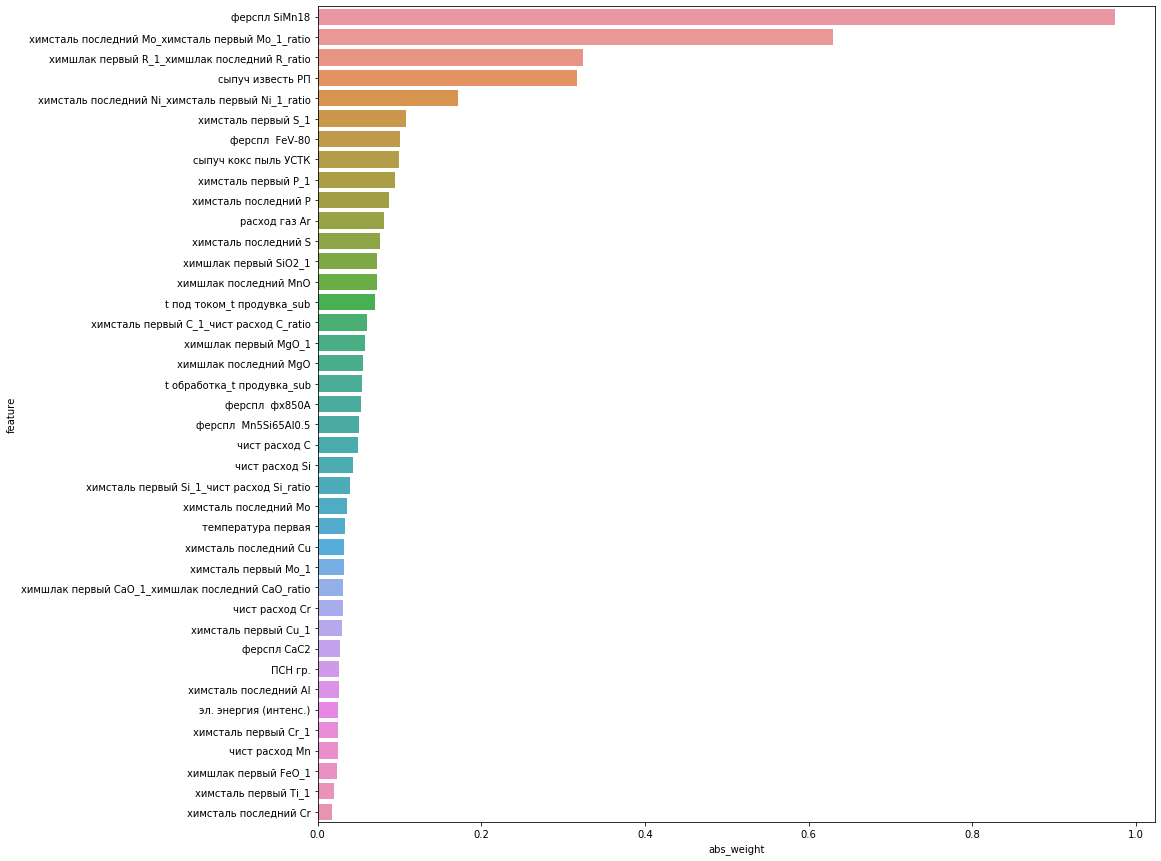

In [83]:
top_features = plot_importance(lasso, train_X.columns)

In [84]:
reg_top = LinearRegression()
scores = evaluate_model(train_X, val_X, np.log(train_y+0.001), np.log(val_y+0.001), map_features(top_features), reg_top)
scores

train_RMSE  train_R2  val_RMSE    val_R2
0    0.148301  0.416812  0.154126  0.411409

На топ-фичах результат стал хуже.

#### Следующий таргет

In [85]:
target = 'химшлак последний SiO2'
features_2 = set(df.columns) - set([target]) # добавим колонку Al2O3
X, y = df.loc[train_test_idx, features_2], df.loc[train_test_idx, target]
X['химшлак последний Al2O3'] = reg_Al2O3.predict(mapper.transform(X[features])) # добавим предыдущее предсказание
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=0, test_size=.3, shuffle=True)

In [86]:
reg_SiO2 = LinearRegression()
scores = evaluate_model(train_X, val_X, np.log(train_y+0.001), np.log(val_y+0.001), map_features(features_2), reg_SiO2)
scores

train_RMSE  train_R2  val_RMSE   val_R2
0     0.02145  0.946654  0.022132  0.94565

Результат очень неплохой.

In [87]:
mapper2 = DataFrameMapper(map_features(features_2), df_out=True)
_ = mapper2.fit(train_X[features_2]) 

## Предсказания

In [88]:
# сначала для Al2O3
X = df.loc[pred_idx, features]
Al2O3_preds = reg_Al2O3.predict(mapper.transform(X))
# потом для SiO2 на расширенном наборе фич
X['химшлак последний Al2O3'] = Al2O3_preds
SiO2_preds = reg_SiO2.predict(mapper2.transform(X))

In [89]:
preds = pd.DataFrame(np.array([Al2O3_preds, SiO2_preds]).T, columns=TARGETS, index=pred_idx)
preds

химшлак последний Al2O3  химшлак последний SiO2
nplv                                                        
г6837?3<87?                 1.609998                3.002710
г683863<887                 1.440880                3.214823
г683863<888                 1.459637                3.136295
г683863<889                 1.496598                3.173308
г683863<968                 1.484840                3.260526
...                              ...                     ...
г683863>6?8                 1.394120                3.229052
г683863>6?9                 1.437453                3.290961
г683863>6?;                 1.617502                3.124378
г683863>6?<                 1.629749                3.098958
г683863>77<                 1.537410                3.238743

[1042 rows x 2 columns]

In [ ]:
# preds.to_csv('Прогноз_Al2O3_SiO2.csv')

In [119]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def compute_metrics(y_true, y_pred):
    return np.array([r2_score(y_true, y_pred), mean_absolute_error(y_true, y_pred), \
                    mean_squared_error(y_true, y_pred), mean_absolute_percentage_error(y_true, y_pred)])

    '''
    print(f'R2 : {r2_score(y_true, y_pred)}')
    print(f'MAE : {mean_absolute_error(y_true, y_pred)}')
    print(f'MSE : {mean_squared_error(y_true, y_pred)}')
    print(f'MAPe : {mean_absolute_percentage_error(y_true, y_pred)}')
    '''
    
def mean_xgboost_pred(epochs, data):
    metrics = np.zeros((len(TARGETS), 4))
    for i in range(epochs):
        for j in range(len(TARGETS)):
            X_train, X_test, y_train, y_test = train_test_split(
                data.drop(columns = TARGETS).values,
                data[TARGETS].values,
                test_size=0.3, random_state=i)
            gr_reg = XGBRegressor(n_estimators=500, learning_rate=0.01)
            gr_reg.fit(X_train, y_train[:, j], 
                     early_stopping_rounds=5, 
                     eval_set=[(X_val, y_val[:, j])],
                     verbose=False)

            y_pred = gr_reg.predict(X_test)
            metrics[j] += compute_metrics(y_test[:, j], y_pred)
            
    metrics /= epochs
    return metrics

# XGBOOST

In [175]:
df = pd.read_csv('../SUBMISSION/Исходные данные.csv', sep=';', decimal=',', index_col=0, parse_dates=['DT'])
df = df.set_index('nplv').sort_values('DT')
targets = ['химшлак последний Al2O3', 'химшлак последний CaO', 'химшлак последний R', 'химшлак последний SiO2']
df_targets = df[targets]
df = df[df['МАРКА'] == 'Э76ХФ'] 
row_nan_per = df.isnull().sum(axis=1) / df.shape[1]
df.drop(row_nan_per[row_nan_per >= 0.3].index, axis=0, inplace=True)
df.shape

(4425, 83)

In [177]:
df.loc[~df['химшлак последний CaO'].isnull()].shape

(4425, 83)

In [178]:
df.drop(['ПРОФИЛЬ','МАРКА','DT'], axis=1, inplace=True)

null_cols = list(nuls.loc[nuls['%_nulls']>0.5].feature)
future_cols = [col for col in df.columns if 'последний' in col.lower()]

df_targets = df[targets]

cols2drop = null_cols+future_cols
df.drop(cols2drop, axis=1, inplace=True)


nan_cols=[col for col in df.columns if df[col].isnull().values.any()]
for col in nan_cols:
    knn_impute(df, col)
    
df.drop(nan_cols, axis=1, inplace=True)
df

t вып-обр  t под током  t продувка  температура первая  \
nplv                                                                  
г6837?3<87?       29.0    24.400000   41.033333              1557.0   
г683863<886       26.0    13.866667   44.066667              1601.0   
г683863<887       24.0    17.950000   43.350000              1593.0   
г683863<888       17.0    19.816667   46.183333              1589.0   
г683863<889       20.0    17.033333   48.500000              1597.0   
...                ...          ...         ...                 ...   
г68386398;7       33.0    17.850000   42.200000              1586.0   
г68386398;8       34.0    18.533333   42.050000              1579.0   
г68386398;9       13.0    20.750000   47.850000              1578.0   
г68386398;:       14.0    18.633333   40.683333              1570.0   
г68386398;;       12.0    21.083333   44.366667              1602.0   

             температура последняя  Ar (интенс.)  эл. энергия (интенс.)  \
nplv                                                                      
г6837?3<87?                 1580.0     13.606742           12809.016393   
г683863<886                 1591.0      8.074721           12816.346154   
г683863<887                 1586.0     13.801968           12511.420613   
г683863<888                 1589.0     12.664958           12998.149706   
г683863<889                 1592.0     10.298350           12987.475538   
...                            ...           ...                    ...   
г68386398;7                 1581.0     13.672038           13472.268908   
г68386398;8                 1574.0     14.320095           12910.791367   
г68386398;9                 1580.0     10.561526           13200.000000   
г68386398;:                 1578.0     13.200000           13878.354204   
г68386398;;                 1590.0     10.665795           12638.418972   

             произв жидкая сталь  произв количество обработок  \
nplv                                                            
г6837?3<87?                115.5                          1.0   
г683863<886                111.6                          1.0   
г683863<887                115.8                          1.0   
г683863<888                116.3                          1.0   
г683863<889                115.0                          1.0   
...                          ...                          ...   
г68386398;7                115.4                          1.0   
г68386398;8                117.4                          1.0   
г68386398;9                116.8                          1.0   
г68386398;:                114.8                          1.0   
г68386398;;                113.6                          1.0   

             произв  количество плавок  ...  сыпуч  шпат плав._knn  \
nplv                                    ...                          
г6837?3<87?                        1.0  ...                  0.123   
г683863<886                        1.0  ...                  0.094   
г683863<887                        1.0  ...                  0.061   
г683863<888                        1.0  ...                  0.059   
г683863<889                        1.0  ...                  0.035   
...                                ...  ...                    ...   
г68386398;7                        1.0  ...                  0.039   
г68386398;8                        1.0  ...                  0.049   
г68386398;9                        1.0  ...                  0.060   
г68386398;:                        1.0  ...                  0.063   
г68386398;;                        1.0  ...                  0.082   

             ферспл CaC2_knn  ферспл  FeV-80_knn  ферспл  Mn5Si65Al0.5_knn  \
nplv                                                                         
г6837?3<87?             0.02            0.051939                     0.112   
г683863<886             0.02            0.050854                     0.102   
г683863<887             0.02            0.05

In [179]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X, y = df, df_targets['химшлак последний CaO']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [180]:
TARGETS = df_targets.columns
last_analysis_cols = [col for col in df.columns if (col.find('последний') != -1) & (col not in TARGETS)]
df.columns

Index(['t вып-обр', 't под током', 't продувка', 'температура первая',
       'температура последняя', 'Ar (интенс.)', 'эл. энергия (интенс.)',
       'произв жидкая сталь', 'произв количество обработок',
       'произв  количество плавок', 'произв количество плавок (цел)',
       'расход газ Ar', 'эл. энергия', 'химсталь первый Al_1',
       'химсталь первый C_1', 'химсталь первый Cr_1', 'химсталь первый Cu_1',
       'химсталь первый Mn_1', 'химсталь первый Mo_1', 'химсталь первый Ni_1',
       'химсталь первый P_1', 'химсталь первый S_1', 'химсталь первый Si_1',
       'химсталь первый Ti_1', 'химсталь первый V_1', 'химшлак первый CaO_1',
       'химшлак первый FeO_1', 'химшлак первый MnO_1', 'химшлак первый R_1',
       't обработка_knn', 'ПСН гр._knn', 'чист расход C_knn',
       'чист расход Cr_knn', 'чист расход Mn_knn', 'чист расход Si_knn',
       'чист расход V_knn', 'сыпуч известь РП_knn', 'сыпуч кокс пыль УСТК_knn',
       'сыпуч  кокс. мелочь КМ1_knn', 'сыпуч  шпат плав._k

In [181]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
gr_reg = XGBRegressor()
param_grid = {'n_estimators': range(100,1000,100), 'booster':['gbtree','gblinear']}

In [182]:
import warnings
warnings.filterwarnings('ignore')
clf = GridSearchCV(gr_reg, param_grid, refit = 'r2', verbose=2, scoring='r2')
model = clf.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ...................booster=gbtree, n_estimators=100; total time=   0.3s
[CV] END ...................booster=gbtree, n_estimators=100; total time=   0.3s
[CV] END ...................booster=gbtree, n_estimators=100; total time=   0.3s
[CV] END ...................booster=gbtree, n_estimators=100; total time=   0.3s
[CV] END ...................booster=gbtree, n_estimators=100; total time=   0.3s
[CV] END ...................booster=gbtree, n_estimators=200; total time=   0.6s
[CV] END ...................booster=gbtree, n_estimators=200; total time=   0.7s
[CV] END ...................booster=gbtree, n_estimators=200; total time=   0.6s
[CV] END ...................booster=gbtree, n_estimators=200; total time=   0.6s
[CV] END ...................booster=gbtree, n_estimators=200; total time=   0.6s
[CV] END ...................booster=gbtree, n_estimators=300; total time=   1.0s
[CV] END ...................booster=gbtree, n_es

In [183]:
model.best_params_

{'booster': 'gblinear', 'n_estimators': 400}

In [184]:
estimator = model.best_estimator_
y_pred = estimator.predict(X_test)

In [185]:
compute_metrics(y_test, y_pred)

array([ 0.18494241,  2.61063155, 11.56660437,  4.74292741])